# Задача кластеризации. Сегментация клиентов онлайн-магазина подарков.

Александр Журавлев DST-120
***

# 1. Постановка задачи

**Важные инсайты**:

Исходная таблица представляет собой данные о транзакциях, произведённых за указанный период. Задача — кластеризация клиентов на основе совершённых ими транзакций.    

- В заказе может быть указано отрицательное количество товара (Quantity < 0). Как правило, это свидетельствует о возврате товара, но также может означать скидки.   
- В системе учёта транзакций на каждый уникальный товар в заказе заводится отдельная транзакция.
Например, в заказе под номером '536365' содержится семь уникальных товаров.
- На возврат каждого уникального товара также заводится отдельная транзакция (уникальная запись в таблице).

- Номер заказа (InvoiceNo) может содержать не только числа, но и символы. 
Например, символ 'C' перед номером заказа указывает на признак возврата. То есть в таблице должна находиться запись с такими же идентификаторами клиента и товара, но номером заказа без символа 'C' и с положительным количеством товара.

- Код товара (StockCode) также может содержать не только числа, но и символы. 
Например, 'D' означает, что товар является скидочным и на такие товары нет аналогов с положительным числом товаров в заказе.

Однако не все заказы с отрицательным количеством товара имеют в таблице свои аналоги (контрагентов).    
Дело в том, что заказ на покупку этого товара от клиента поступил раньше декабря 2010 года, а этих данных в нашей таблице нет.       
Клиент может отменить не весь заказ, а только его часть (5 декабря клиент покупает 12 единиц товара, а 8 декабря оформляет возврат только на одну единицу товара).

# 2. Импорт библиотек и знакомство со структурой данных

In [1]:
import pandas as pd
import numpy as np

# для стандартизации, нормализации
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# для снижения размерности
from sklearn.decomposition import PCA
# алгоритмы кластеризации и расчет коэффициента силуэта
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

# для создания пайплайнов
from sklearn.pipeline import Pipeline

# для визуализации
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
# настройка визуализации
%matplotlib inline
plt.style.use('seaborn-v0_8')
%config InlineBackend.figure_format = "retina"

# дполнительные модули
import re
import datetime

import warnings 
warnings.filterwarnings("ignore")



Первым делом необходимо понять, с какими данными нам предстоит работать, и произвести базовую предобработку данных — перевести признаки в необходимые для дальнейшей работы форматы.

Познакомиимся с исходными данными поближе:

* Проведем статистический анализ исходных данных, посмотрев на основные диапазоны исходных признаков.
* Узнаем, сколько уникальных клиентов совершали транзакции в указанный период.
* Узнаем, из каких стран совершались транзакции.
* Исследуем данные на наличие пропусков и дубликатов.
* Переведем столбцы в корректные форматы (например, даты в формат datetime).

In [2]:
# загрузим исходные данные
data = pd.read_csv(
    "./data/data.csv", 
    encoding="ISO-8859-1", 
    dtype={'CustomerID': str,'InvoiceID': str}
)
print('Data shape: {}'.format(data.shape))
data.head(5)

Data shape: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  object 
 7   Country      541909 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 33.1+ MB


In [4]:
# переведем даты транзакций в формат datetime
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
# узнаем за какой период представлены данные
print('Date interval {} to {}'.format(data['InvoiceDate'].dt.date.min(), data['InvoiceDate'].dt.date.max()))

Date interval 2010-12-01 to 2011-12-09


# 3. Преобразование, очистка и анализ данных

## 3.1. Преобразование и очистка данных о транзакциях

### 3.1.1. Пропуски

Пропуски в столбце с идентификатором клиента (CustomerID) и описанием товара свидетельствуют о некорректных/незавершённых транзакциях. Удалим их из данных.

**Примечание.** Если посмотреть на распределение пропусков в столбцах Description и CustomerID, то можно заметить, что достаточно удалить строки, содержащие пропуски в столбце CustomerID, тогда пропуски в столбце Description удаляются автоматически.


In [5]:
# ищем пропуски
display(data.isnull().sum())
# сколько строк с пропущенными значениями
print(f'Количество строк, содержащих пропуски {data[data.isna().any(axis=1)].shape[0]}')

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Количество строк, содержащих пропуски 135080


In [6]:
# удаляем пропуски
data.dropna(inplace=True)
# удостоверимся, что пропусков больше нет
data.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

### 3.1.2. Дубликаты

Проверим данные на наличие дубликатов. Удалим их из данных.


In [7]:
# поиск дубликатов
print(f'Число найденных дубликатов: {data[data.duplicated()].shape[0]}')

Число найденных дубликатов: 5225


In [8]:
# удаляем дубликаты
data.drop_duplicates(inplace=True)
print(f'Число найденных дубликатов: {data[data.duplicated()].shape[0]}')

Число найденных дубликатов: 0


### 3.1.3. Транзакции с отрицательным количеством товара

Из приведённых выше инсайтов о данных мы узнали все особенности отмены заказов. Когда мы будем сегментировать клиентов, мы будем определять их покупательскую способность. При расчёте покупательской способности нам будет очень важно учесть возвраты этого клиента.

Чтобы подсчитать количество возвратов, для начала нам надо определить, сколько уникальных товаров указано в транзакции (корзине) для каждой уникальной пары «клиент — заказ»:


In [9]:
temp = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket.head()

,CustomerID,InvoiceNo,Number of products
0,12346,541431,1
1,12346,C541433,1
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24


In [10]:
# узнаем % отмененных транзакций 
data_copy = data.copy()
data_copy['is_canceled'] = data_copy['InvoiceNo'].apply(
    lambda x: 1 if x[0] == 'C' else 0
)
data_copy['is_canceled'].value_counts(normalize=True)

0    0.977909
1    0.022091
Name: is_canceled, dtype: float64

In [11]:
# узнаем % отмененных уникальных заказов
nb_products_per_basket['is_canceled'] = nb_products_per_basket['InvoiceNo'].apply(
    lambda x: 1 if x[0] == 'C' else 0
)
nb_products_per_basket['is_canceled'].value_counts(normalize=True)

0    0.835331
1    0.164669
Name: is_canceled, dtype: float64

**Примечание.** Более 16 % уникальных заказов являются возвратами. Интересный факт: если подсчитать количество транзакций, содержащих признак возврата, в изначальной таблице, где на каждый уникальный товар заведена отдельная строка, то получается, что количество возвратов менее 1 %. Однако это число было бы некорректным.

Создадим в ваших данных о транзакциях признак `QuantityCanceled`. Этот признак будет указывать на количество отменённого впоследствии товара для каждой транзакции, на которую найдётся противоположная ей транзакция с возвратом. Для транзакций, для которых не было возвратов, признак будет равен 0. Для транзакций, для которых указано отрицательное количество товара, но в данных отсутствует контрагент, признак будет пустым.

В качестве вспомогательного инструмента подготовлена функция `get_quantity_canceled()`. Эта функция принимает на вход таблицу с транзакциями и возвращает объект `Series` — столбец, в котором указано количество отменённого впоследствии товара для каждой транзакции. Если транзакция не имеет контрагента, этот признак помечается как `NaN`.

Отметим, что эта функция не учитывает сложный случай, когда количество отменённого товара в транзакции-возврате больше, чем количество товара, которое указано в любой из отдельных транзакций на покупку (это случай, когда клиент сделал несколько заказов одного и того же товара, а потом оформил возврат на все товары разом).

In [12]:
def get_quantity_canceled(data):
    """Функция для создания признака количества отменённых заказов. 
    Функция принимает на вход таблицу и возвращает столбец, в котором указано количество отменённого впоследствии товара для кажой транзакции.
    Если транзакция с отрицательным количеством товара не имеет контрагента, данный признак помечается как NaN.

    Args:
        data (DataFrame): таблица с транзакциями

    Returns:
        Series: столбец с количеством отменённого товара
    """
    # Инициализируем нулями Series той же длины, что и столбцы таблицы.
    quantity_canceled = pd.Series(np.zeros(data.shape[0]), index=data.index)    
    negative_quantity = data[(data['Quantity'] < 0)].copy()
    for index, col in negative_quantity.iterrows():
        # Создаём DataFrame из всех контрагентов
        df_test = data[(data['CustomerID'] == col['CustomerID']) &
                       (data['StockCode']  == col['StockCode']) & 
                       (data['InvoiceDate'] < col['InvoiceDate']) & 
                       (data['Quantity'] > 0)].copy()
        # Транзация-возврат не имеет контрагента — ничего не делаем
        if (df_test.shape[0] == 0): 
            # Помечаем столбец как пропуск
            quantity_canceled.loc[index] = np.nan
        # Транзакция-возврат имеет ровно одного контрагента
        # Добавляем количество отменённого товара в столбец QuantityCanceled 
        elif (df_test.shape[0] == 1): 
            index_order = df_test.index[0]
            quantity_canceled.loc[index_order] = -col['Quantity']       
        # Транзакция-возврат имеет несколько контрагентов
        # Задаём количество отменённого товара в столбец QuantityCanceled для той транзакции на покупку,
        # в которой количество товара больше количества товаров в транзакции-возврате.
        elif (df_test.shape[0] > 1): 
            df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
            for ind, val in df_test.iterrows():
                if val['Quantity'] < -col['Quantity']: 
                    continue
                quantity_canceled.loc[ind] = -col['Quantity']
                break    
    return quantity_canceled

data['QuantityCanceled'] = get_quantity_canceled(data)

In [13]:
# узнаем сколько транзакций не имеют контрагентов
print(f'Количество строк, содержащих пропуски (нет контрагентов) {data[data.isna().any(axis=1)].shape[0]}')

Количество строк, содержащих пропуски (нет контрагентов) 1303


In [14]:
# транзакции с отрицательным количеством товара
data[data['Quantity'] < 0].shape[0]

8872

In [15]:
# удаляем строчки с пропусками (нет контрагентов) и транзакции с отрицательным количеством товара
print(f'размерность данных до удаления {data.shape}')
data.dropna(inplace=True)
data = data[data['Quantity'] >= 0]
print(f'размерность данных после удаления {data.shape}')

размерность данных до удаления (401604, 9)
размерность данных после удаления (392732, 9)


### 3.1.4. Специализированные транзакции

Следующая задача — обработать специальные виды транзакций, которые обозначаются латинскими буквами.

В данных присутствует шесть специальных видов транзакций. 

Чтобы понять, что означают эти коды, можно заглянуть в столбец с описанием (Description), например POST означает почтовые расходы, C2 — расходы на транспортировку, BANK CHARGES — банковские расходы.

Специальные операции не характеризуют покупательскую способность клиентов, так как не относятся напрямую к их покупкам, поэтому такие записи нам не нужны. Удалим все специальные транзакции из таблицы.

In [16]:
# создадим новый признак со специальными видами транзакций
data['chars_stock_code'] = data['StockCode'].str.findall(r'^[a-zA-Z]+')
data['chars_stock_code'] = data['chars_stock_code'].apply(lambda x: x[0] if len(x) > 0 else 'none')
data['chars_stock_code'].value_counts()

none    391183
POST      1099
M          285
C          133
DOT         16
BANK        12
PADS         4
Name: chars_stock_code, dtype: int64

In [17]:
# удаляем строчки со специальными операциями и признак chars_stock_code
print(f'размерность данных до удаления {data.shape}')
data = data[data['chars_stock_code'] == 'none']
data.drop('chars_stock_code', axis=1, inplace=True)
print(f'размерность данных после удаления {data.shape}')

размерность данных до удаления (392732, 10)
размерность данных после удаления (391183, 9)


### 3.1.5. Транзакции с товарами без стоимости

При просмотре описательных статистик можно заметить, что на некоторые товары установлена цена в 0 фунтов стерлингов. Таких транзакций оказывается менее 1 % — можно удалить их.

In [18]:
# узнаем сколько транзакций с товарами без стоимости
data[data['UnitPrice'] == 0].shape[0]

33

In [19]:
# удалим эти транзакции
print(f'размерность данных до удаления {data.shape}')
data = data[data['UnitPrice'] != 0]
print(f'размерность данных после удаления {data.shape}')

размерность данных до удаления (391183, 9)
размерность данных после удаления (391150, 9)


### 3.1.6. Общая стоимость товаров в транзакции

Добавим в датасет общую цену заказа (TotalPrice). Она рассчитывается как:
 
 **общая цена = цена за единицу товара * (количество товаров в заказе - количество возвращённых товаров).**

Этот признак впоследствии поможет рассчитать покупательскую способность каждого из клиентов.

In [20]:
data['TotalPrice'] = data['UnitPrice']*(data['Quantity'] - data['QuantityCanceled'])

## 3.2. Разведывательный анализ

### 3.2.1. Клиенты каких стран покупают чаще

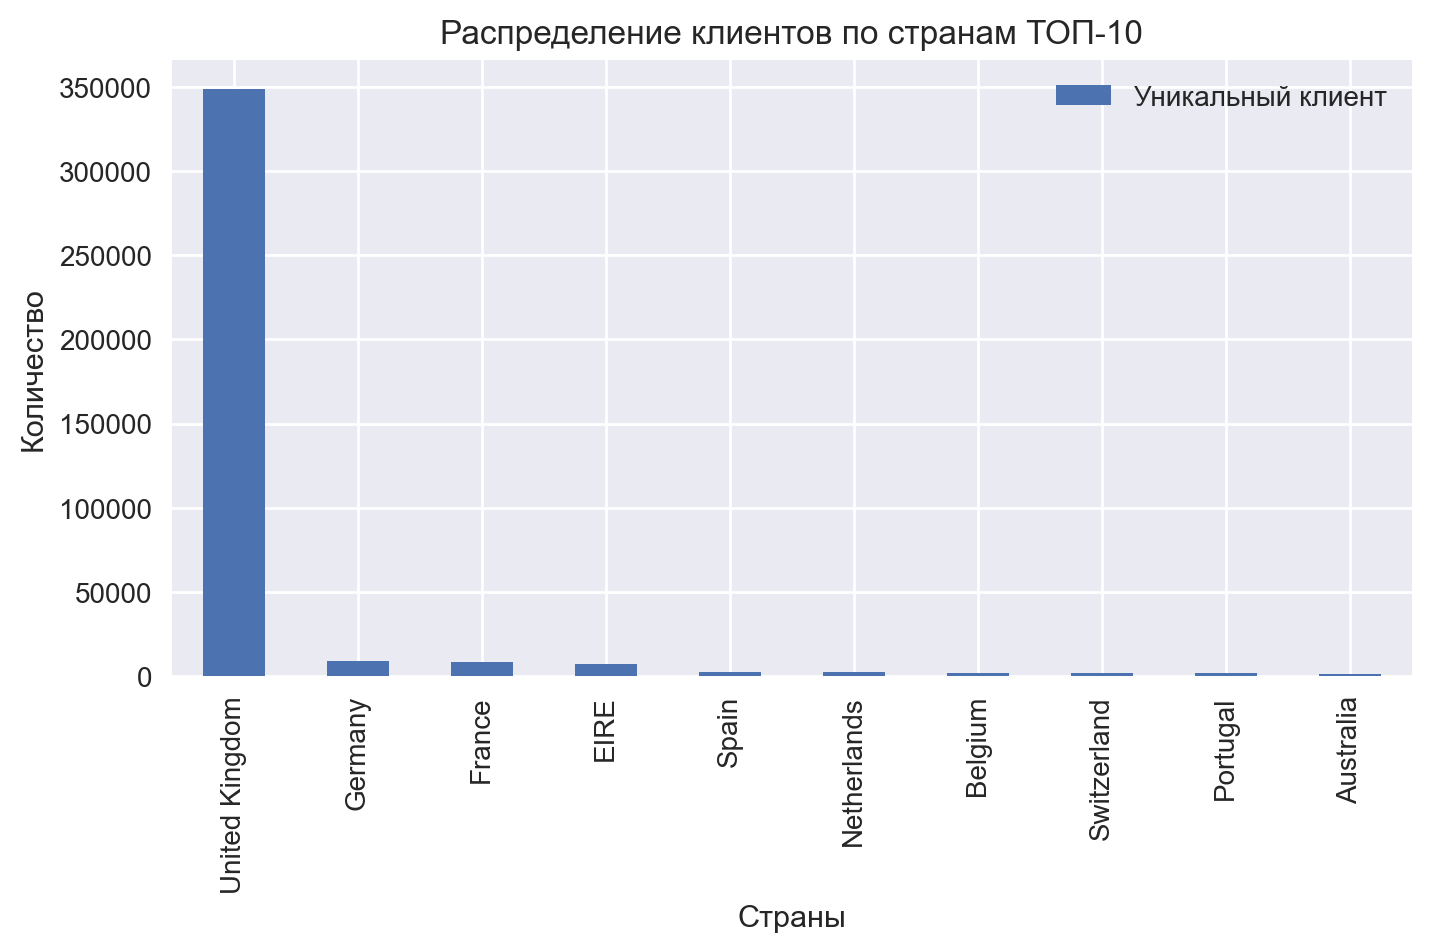

In [21]:
# группируем данные
grouped_data = data.groupby(['Country']).agg({'CustomerID':'count'}).\
    sort_values(by='CustomerID', ascending=False)[:10].reset_index().\
    rename(columns= {'CustomerID':'Уникальный клиент'})
# визуализируем данные
grouped_data.plot(
    figsize=(8, 4),
    x = 'Country',
    kind='bar',
    title='Распределение клиентов по странам ТОП-10',
    xlabel='Страны', 
    ylabel='Количество'
);

### 2.2.2. Клиенты каких стран покупают больше (т.е. осуществляют больше транзакций)

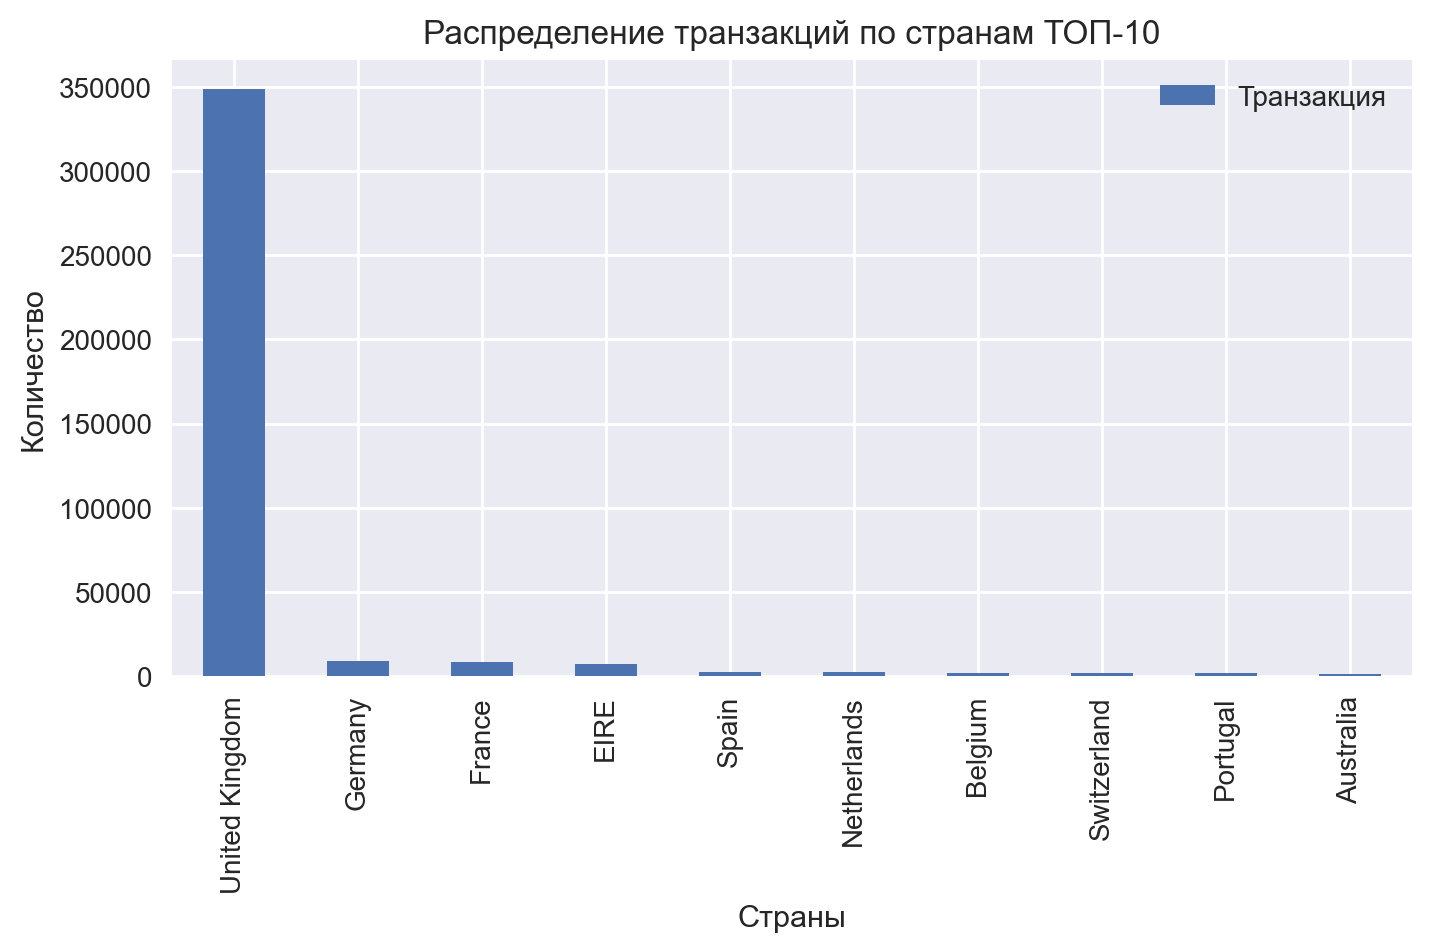

In [22]:
# группируем данные
grouped_data = data.groupby(['Country']).agg({'InvoiceNo':'count'}).\
    sort_values(by='InvoiceNo', ascending=False)[:10].reset_index().\
    rename(columns= {'InvoiceNo':'Транзакция'})
# визуализируем данные
grouped_data.plot(
    figsize=(8, 4),
    x = 'Country',
    kind='bar',
    title='Распределение транзакций по странам ТОП-10',
    xlabel='Страны', 
    ylabel='Количество'
);

Теперь то же, но рассмотрим уникальные транзакции (т.е. покупки).

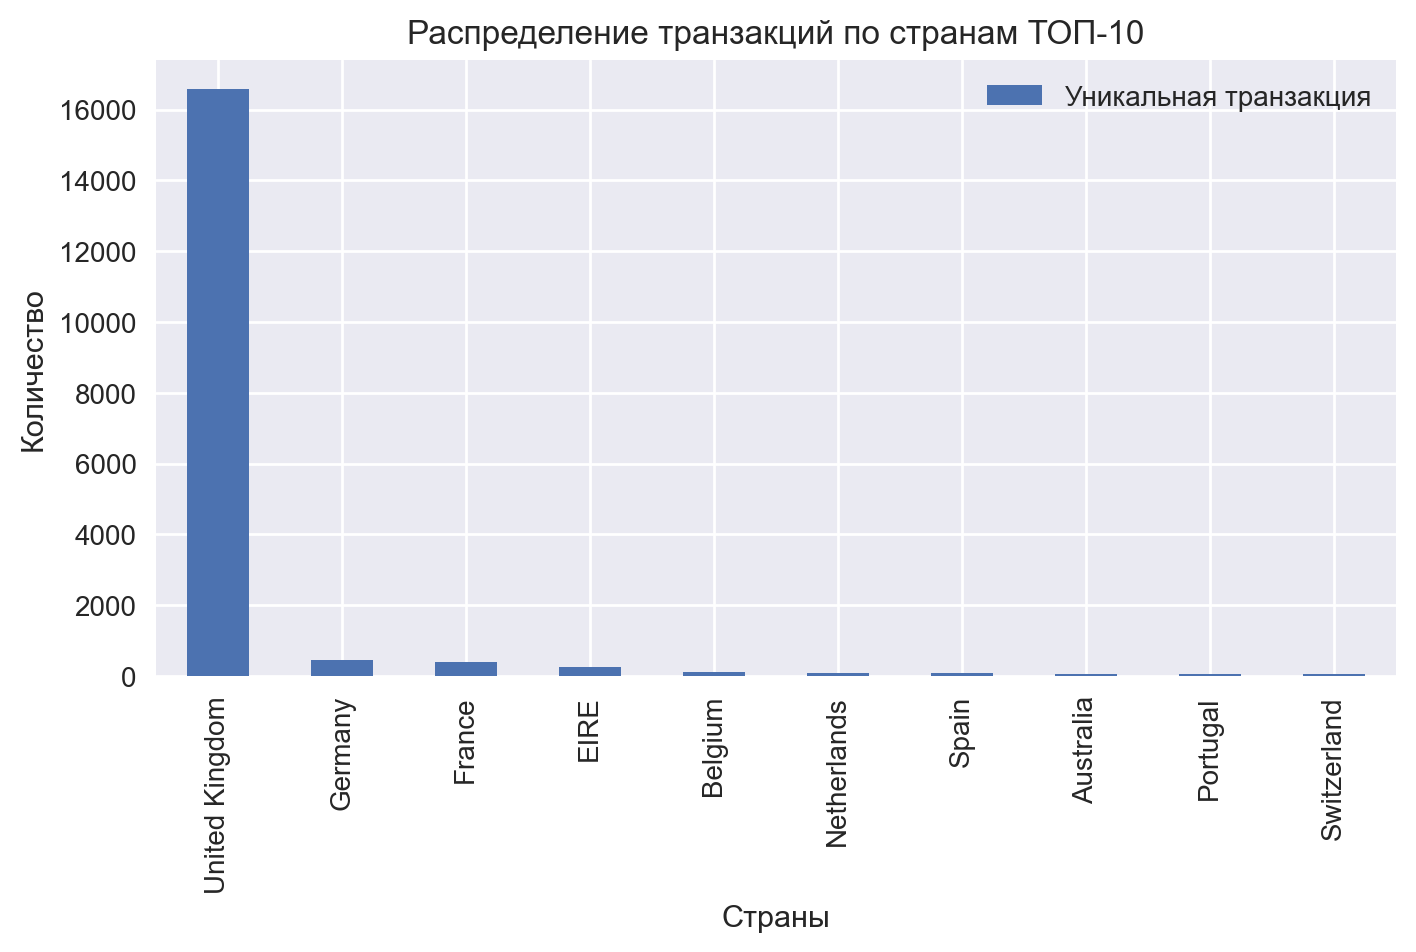

In [23]:
# группируем данные
grouped_data = data.groupby(['Country']).agg(
    invoice_num = pd.NamedAgg(column='InvoiceNo', aggfunc=lambda x: len(x.unique()))
).sort_values(by='invoice_num', ascending=False)[:10].reset_index().\
    rename(columns= {'invoice_num':'Уникальная транзакция'})
# визуализируем данные
grouped_data.plot(
    figsize=(8, 4),
    x = 'Country',
    kind='bar',
    title='Распределение транзакций по странам ТОП-10',
    xlabel='Страны', 
    ylabel='Количество'
);

### 3.2.3. Какие страны принесли наибольшую выручку за представленный период

,Country,Общая выручка
0,United Kingdom,6797691.44
1,Netherlands,283443.54
2,EIRE,247074.57
3,Germany,201520.71
4,France,181529.63
5,Australia,136950.25
6,Switzerland,51863.75
7,Spain,51764.90
8,Belgium,36673.04
9,Sweden,36362.91


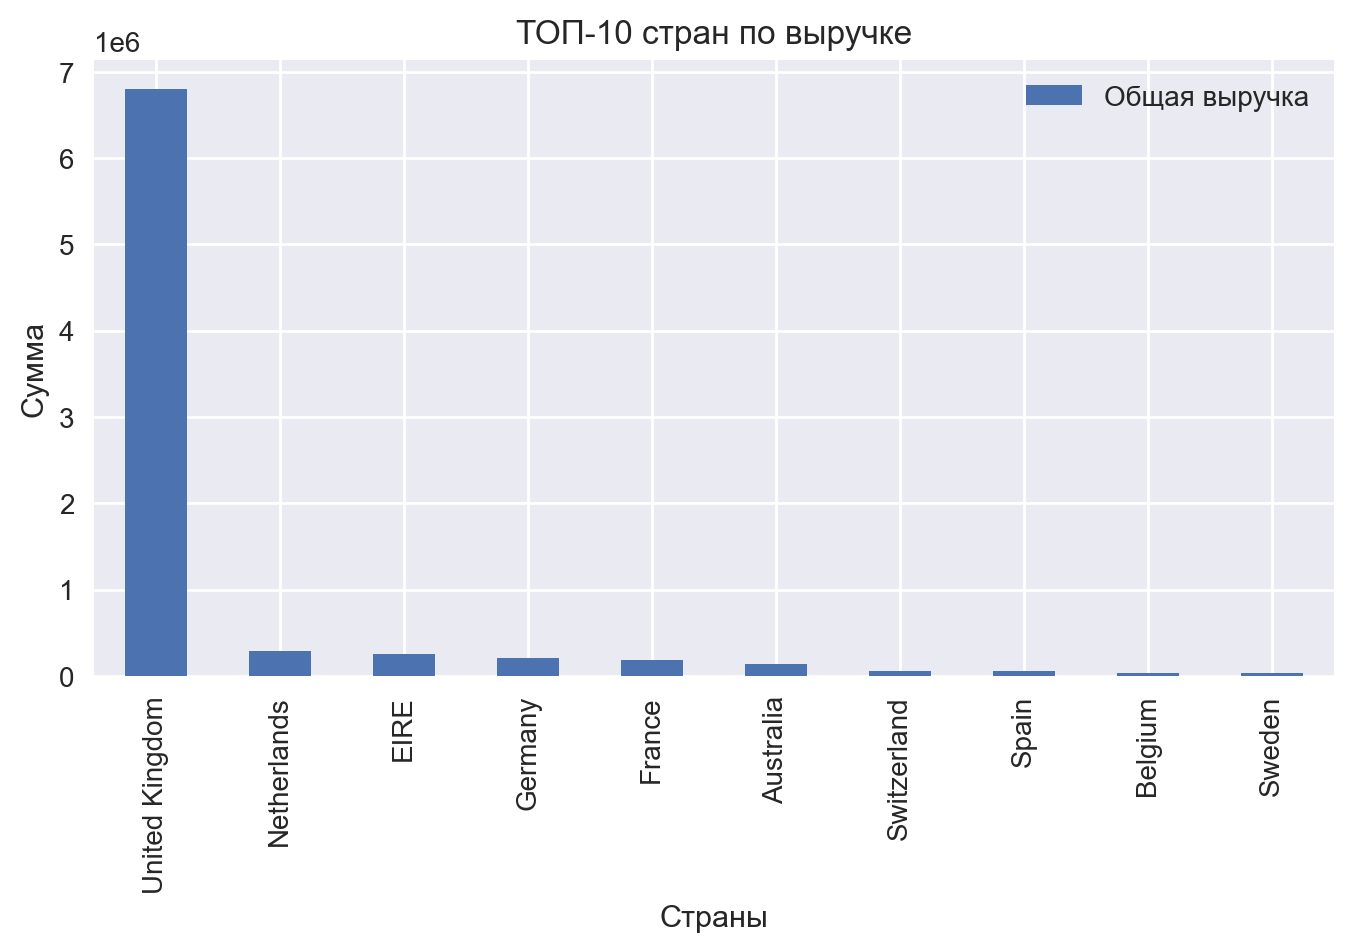

In [24]:
# группируем данные
grouped_data = data.groupby(['Country']).agg({'TotalPrice':'sum'}).\
    sort_values(by='TotalPrice', ascending=False)[:10].reset_index().\
    rename(columns= {'TotalPrice':'Общая выручка'})
# визуализируем данные
grouped_data.plot(
    figsize=(8, 4),
    x = 'Country',
    kind='bar',
    title='ТОП-10 стран по выручке',
    xlabel='Страны', 
    ylabel='Сумма'
);

grouped_data

Неожиданно, но по выручке поднялись вверх Нидерланды и Австралия. Уточним этот момент.

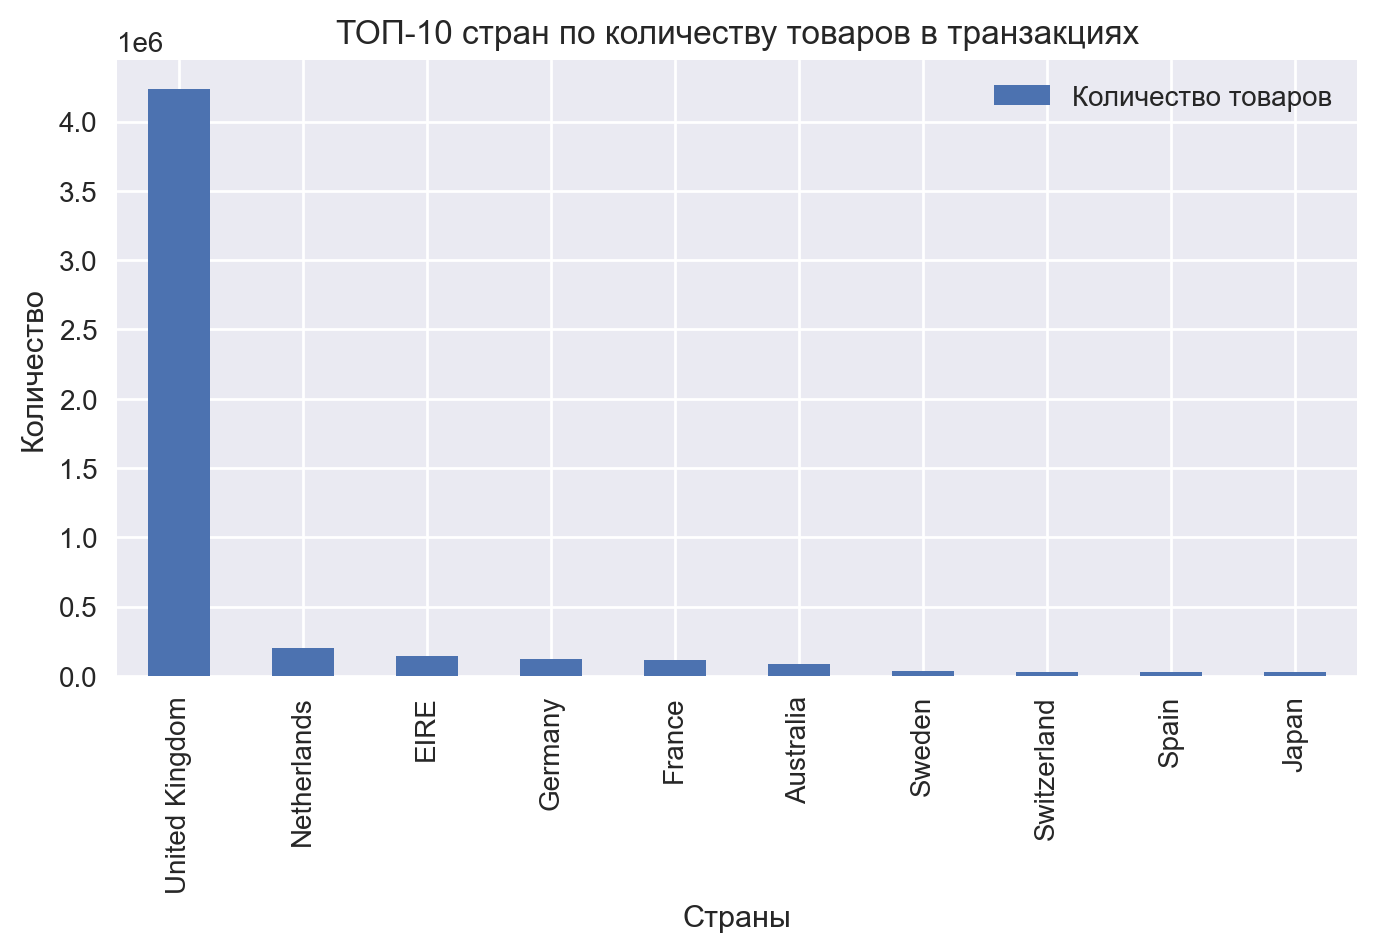

In [25]:
# группируем данные
grouped_data = data.groupby(['Country']).agg({'Quantity':'sum'}).\
    sort_values(by='Quantity', ascending=False)[:10].reset_index().\
    rename(columns= {'Quantity':'Количество товаров'})
# визуализируем данные
grouped_data.plot(
    figsize=(8, 4),
    x = 'Country',
    kind='bar',
    title='ТОП-10 стран по количеству товаров в транзакциях',
    xlabel='Страны', 
    ylabel='Количество'
);

### 3.2.4. Определим присутствует ли сезонность в покупках

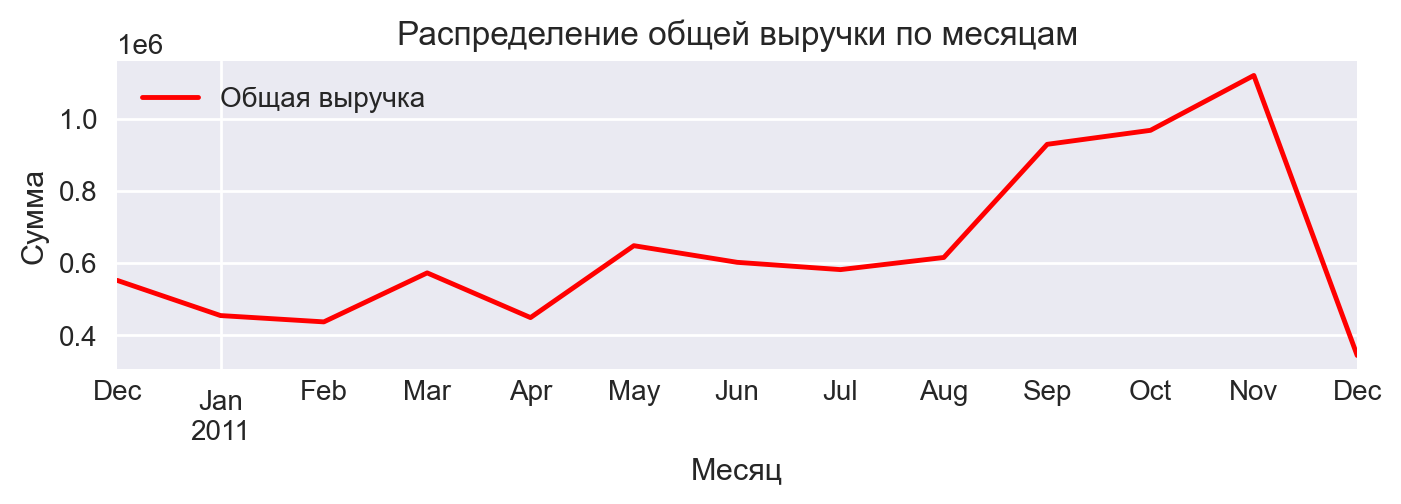

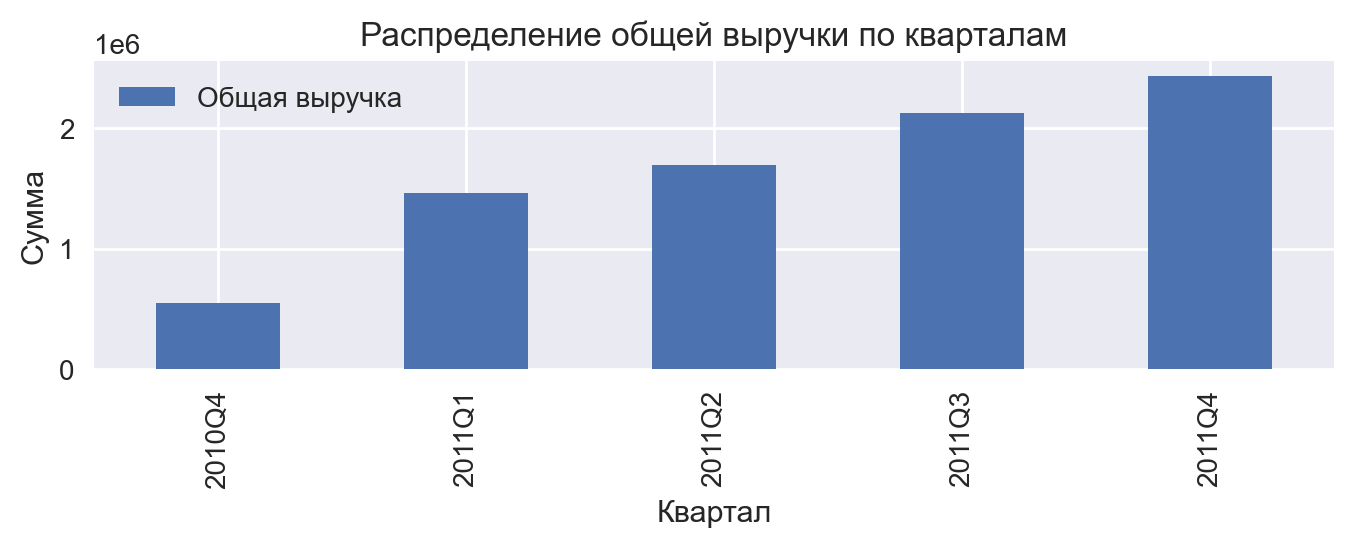

In [26]:
data['InvoiceDate_M'] = data['InvoiceDate'].dt.to_period('M')
data['InvoiceDate_Q'] = data['InvoiceDate'].dt.to_period('Q')

# группируем данные
grouped_data_0 = data.groupby(['InvoiceDate_M']).agg({'TotalPrice':'sum'}).rename(columns= {'TotalPrice':'Общая выручка'})
# визуализируем данные
grouped_data_0.plot(
    figsize=(8, 2),
    kind='line',
    title='Распределение общей выручки по месяцам',
    xlabel='Месяц', 
    ylabel='Сумма',
    color='r'
);

# группируем данные
grouped_data_1 = data.groupby(['InvoiceDate_Q']).agg({'TotalPrice':'sum'}).rename(columns= {'TotalPrice':'Общая выручка'})
# визуализируем данные
grouped_data_1.plot(
    figsize=(8, 2),
    kind='bar',
    title='Распределение общей выручки по кварталам',
    xlabel='Квартал', 
    ylabel='Сумма'
);

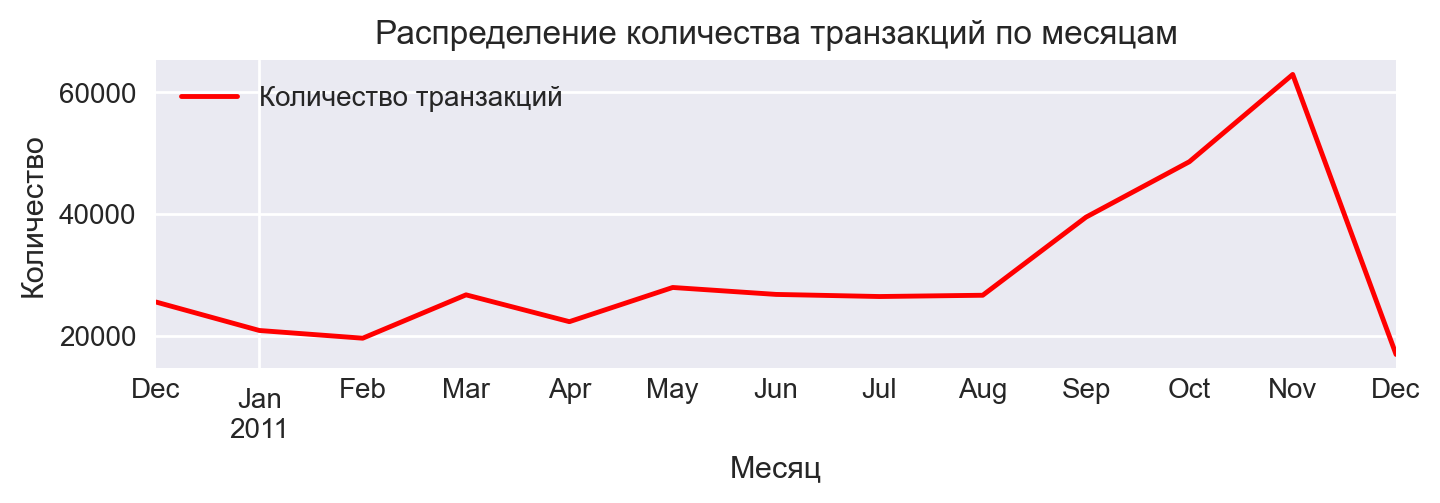

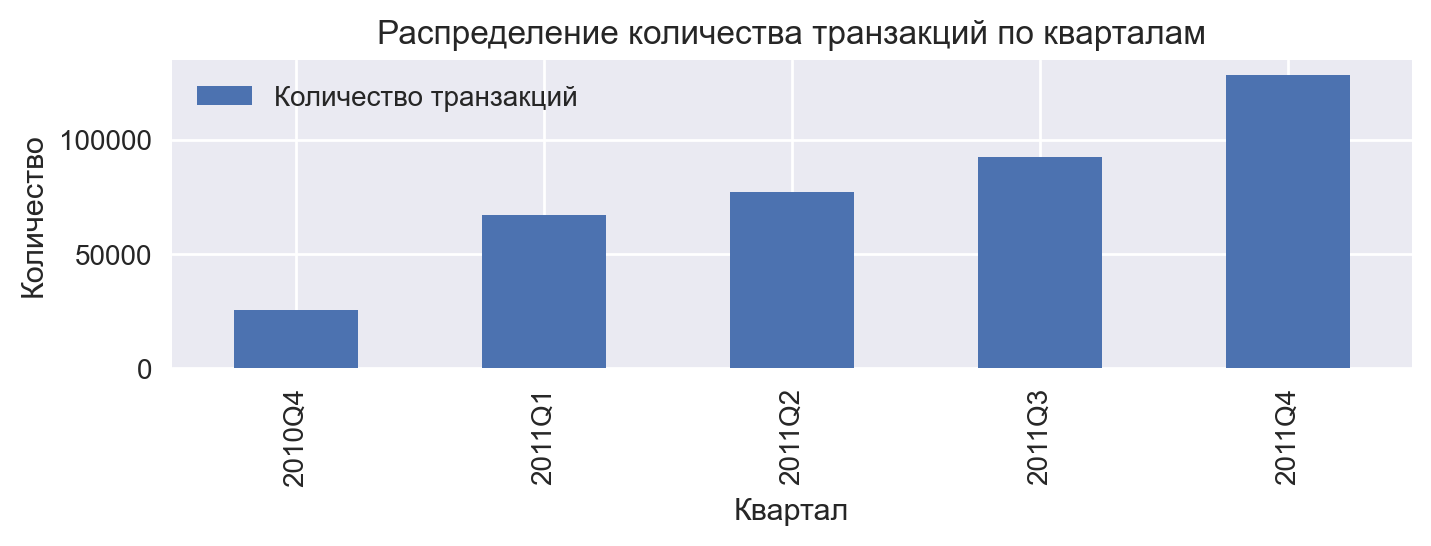

In [27]:
# группируем данные
grouped_data_0 = data.groupby(['InvoiceDate_M']).agg({'InvoiceNo':'count'}).rename(columns= {'InvoiceNo':'Количество транзакций'})
# визуализируем данные
grouped_data_0.plot(
    figsize=(8, 2),
    kind='line',
    title='Распределение количества транзакций по месяцам',
    xlabel='Месяц', 
    ylabel='Количество',
    color='r'
);

# группируем данные
grouped_data_1 = data.groupby(['InvoiceDate_Q']).agg({'InvoiceNo':'count'}).rename(columns= {'InvoiceNo':'Количество транзакций'})
# визуализируем данные
grouped_data_1.plot(
    figsize=(8, 2),
    kind='bar',
    title='Распределение количества транзакций по кварталам',
    xlabel='Квартал', 
    ylabel='Количество'
);

### 3.2.5. Определим среднее количество транзакций по времени суток и дням недели

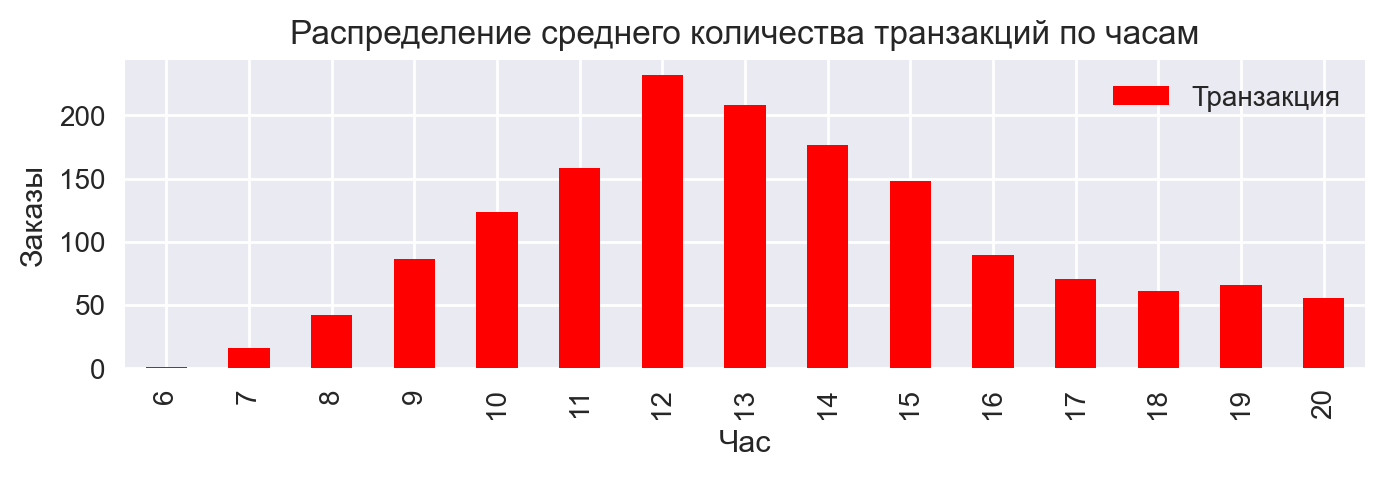

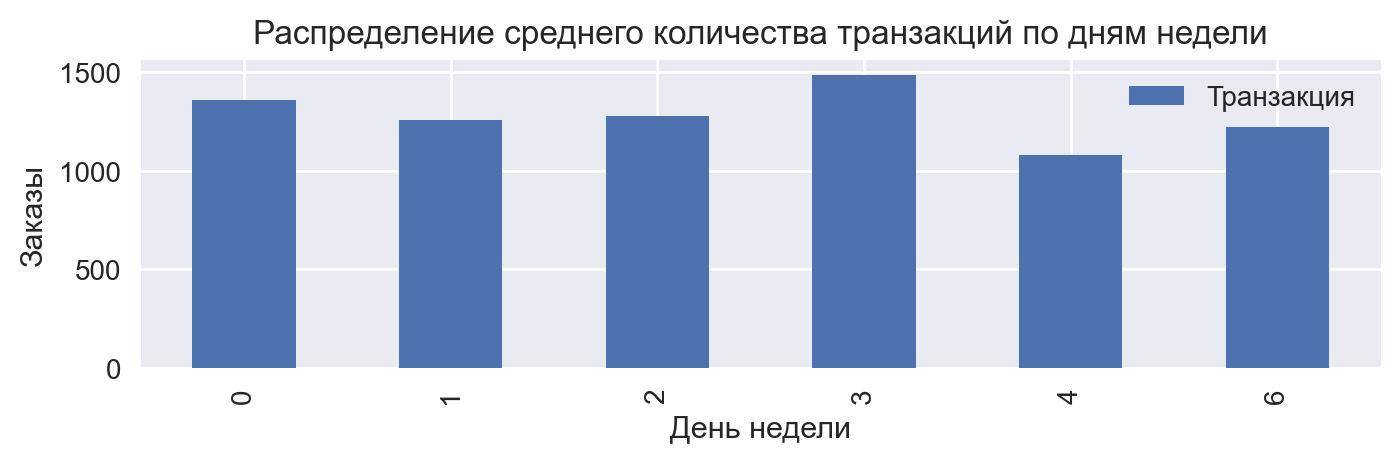

In [28]:
# создадим новые признаки на основе даты транзакции
data['InvoiceDate_date'] = data['InvoiceDate'].dt.date
data['InvoiceDate_hour'] = data['InvoiceDate'].dt.hour
data['InvoiceDate_dow'] = data['InvoiceDate'].dt.day_of_week

# группируем данные
grouped_data = data.groupby(['InvoiceDate_date','InvoiceDate_hour' ]).agg({'InvoiceNo':'count'}).reset_index()
grouped_data_new = grouped_data.groupby(['InvoiceDate_hour']).agg({'InvoiceNo':'mean'}).reset_index().\
    rename(columns={'InvoiceNo':'Транзакция'})

# визуализируем данные
grouped_data_new.plot(
    figsize=(8, 2),
    x='InvoiceDate_hour',
    y='Транзакция',    
    kind='bar',
    title='Распределение среднего количества транзакций по часам',
    xlabel='Час', 
    ylabel='Заказы',
    color='r'
);

# группируем данные
grouped_data = data.groupby(['InvoiceDate_date','InvoiceDate_dow' ]).agg({'InvoiceNo':'count'}).reset_index()
grouped_data_new = grouped_data.groupby(['InvoiceDate_dow']).agg({'InvoiceNo':'mean'}).reset_index().\
    rename(columns={'InvoiceNo':'Транзакция'})

# визуализируем данные
grouped_data_new.plot(
    figsize=(8, 2),
    x='InvoiceDate_dow',
    y='Транзакция',    
    kind='bar',
    title='Распределение среднего количества транзакций по дням недели',
    xlabel='День недели', 
    ylabel='Заказы'
);

Теперь то же, но вместо отдельных транзакций считаем покупки.

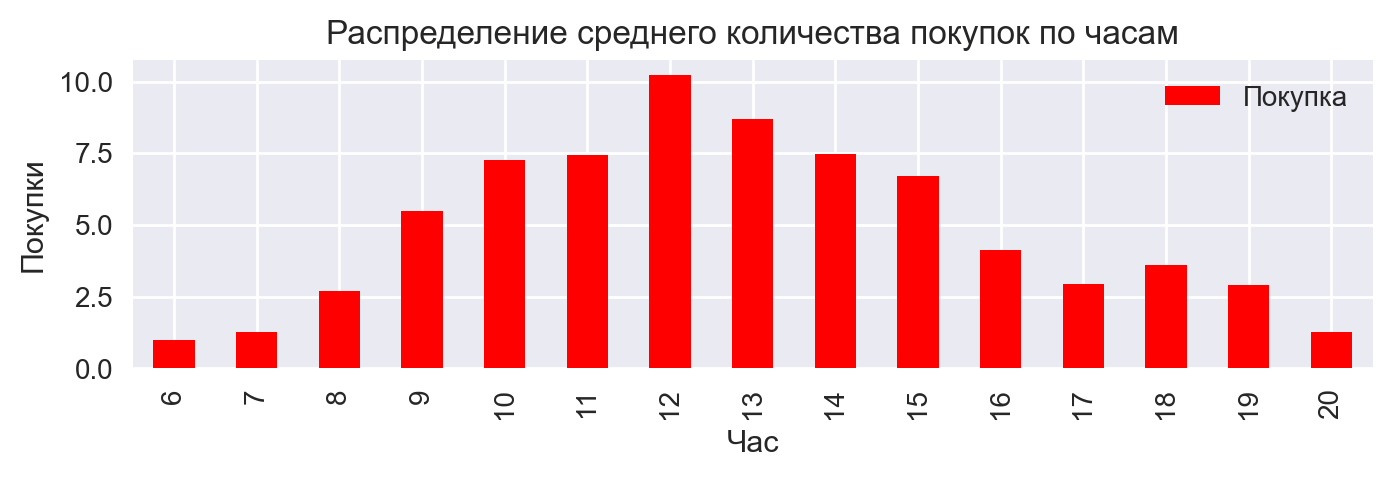

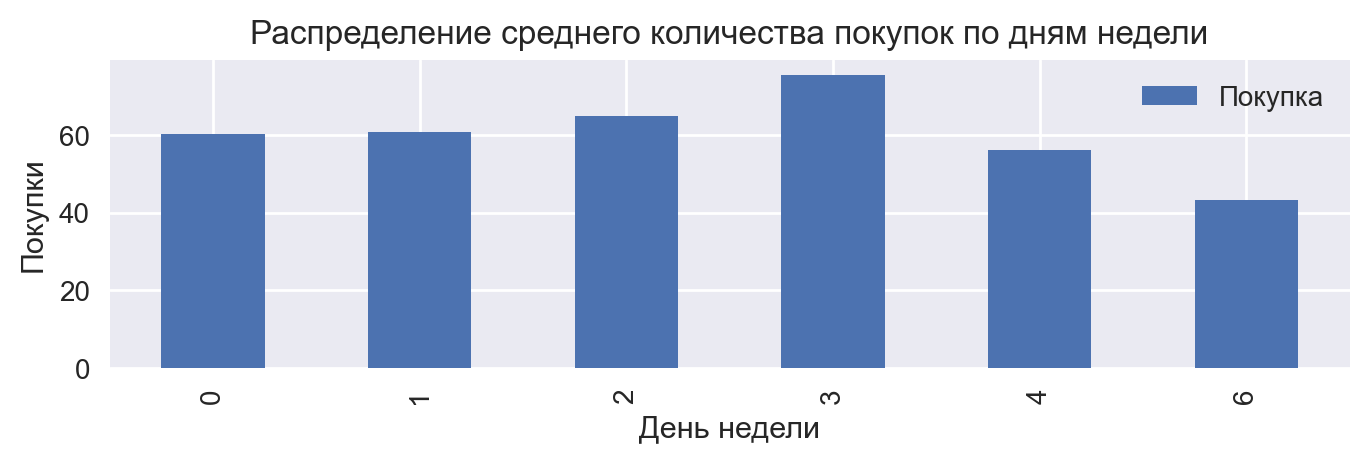

In [29]:
# группируем данные
grouped_data = data.groupby(['InvoiceDate_date','InvoiceDate_hour' ]).agg(
    invoice_num = pd.NamedAgg(column='InvoiceNo', aggfunc=lambda x: len(x.unique()))
).reset_index()
grouped_data_new = grouped_data.groupby(['InvoiceDate_hour']).agg({'invoice_num':'mean'}).reset_index().\
    rename(columns={'invoice_num':'Покупка'})

# визуализируем данные
grouped_data_new.plot(
    figsize=(8, 2),
    x='InvoiceDate_hour',
    y='Покупка',    
    kind='bar',
    title='Распределение среднего количества покупок по часам',
    xlabel='Час', 
    ylabel='Покупки',
    color='r'
);

# группируем данные
grouped_data = data.groupby(['InvoiceDate_date','InvoiceDate_dow' ]).agg(
    invoice_num = pd.NamedAgg(column='InvoiceNo', aggfunc=lambda x: len(x.unique()))
).reset_index()
grouped_data_new = grouped_data.groupby(['InvoiceDate_dow']).agg({'invoice_num':'mean'}).reset_index().\
    rename(columns={'invoice_num':'Покупка'})

# визуализируем данные
grouped_data_new.plot(
    figsize=(8, 2),
    x='InvoiceDate_dow',
    y='Покупка',    
    kind='bar',
    title='Распределение среднего количества покупок по дням недели',
    xlabel='День недели', 
    ylabel='Покупки'
);

В воскресенье довольно много транзакций, но меньше покупок. Уточним эти данные.

Узнаем распределение среднего количества заказанных товаров и средней выручки по дням недели.

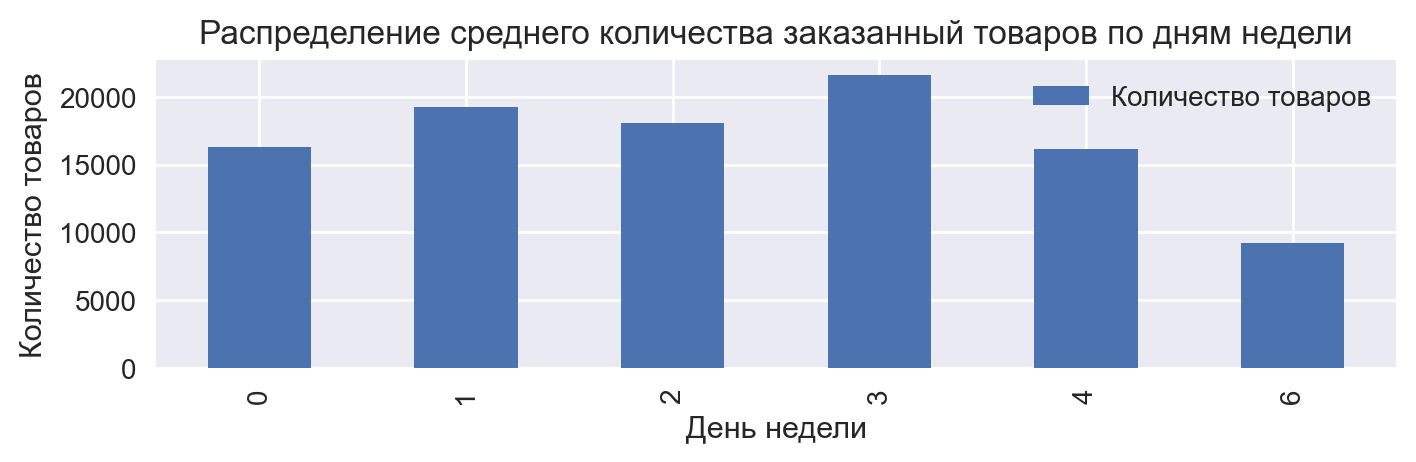

In [30]:
# группируем данные
grouped_data = data.groupby(['InvoiceDate_date','InvoiceDate_dow' ]).agg(
    quantity_num = pd.NamedAgg(column='Quantity', aggfunc='sum')
).reset_index()
grouped_data_new = grouped_data.groupby(['InvoiceDate_dow']).agg({'quantity_num':'mean'}).reset_index().\
    rename(columns={'quantity_num':'Количество товаров'})

# визуализируем данные
grouped_data_new.plot(
    figsize=(8, 2),
    x='InvoiceDate_dow',
    y='Количество товаров',    
    kind='bar',
    title='Распределение среднего количества заказанный товаров по дням недели',
    xlabel='День недели', 
    ylabel='Количество товаров'
);

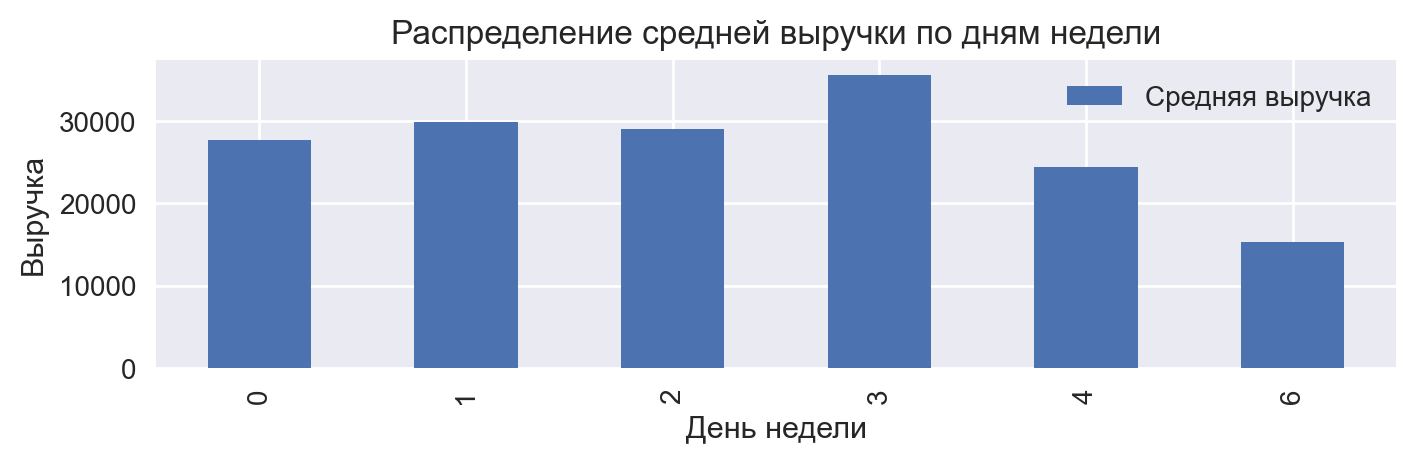

In [31]:
# группируем данные
grouped_data = data.groupby(['InvoiceDate_date','InvoiceDate_dow' ]).agg({'TotalPrice':'sum'}).reset_index()
grouped_data_new = grouped_data.groupby(['InvoiceDate_dow']).agg({'TotalPrice':'mean'}).reset_index().\
    rename(columns={'TotalPrice':'Средняя выручка'})

# визуализируем данные
grouped_data_new.plot(
    figsize=(8, 2),
    x='InvoiceDate_dow',
    y='Средняя выручка',    
    kind='bar',
    title='Распределение средней выручки по дням недели',
    xlabel='День недели', 
    ylabel='Выручка'
);

**Выводы:**
- Подавляющее количество клиентов проживают в Великобритании, также много клиентов в Германии, Франции и Ирландии (вероятно магазин расположен в Великобритании о чем нам говорит и расчетная денежная единица).
- Количество транзакций по странам распределены также.
- По общей выручке лидер прежний - Великобритания, однако на 2-м месте - Нидерланды, а на 6-е место поднялась Австралия. То есть, не смотря на меньшее количество клиентов и транзакций, клиенты из Нидерландов и Австралии покупают большее количество товаров (оптовики?).
- В целом мы видим рост количества транзакций и общей выручки в течение представленного периода, хотя есть просадки в феврале, апреле, и плато летом. Отмечается пик количества трнзакций в ноябре и резкая просадка в декабре 2011 (вероятно из-за того, что данные только по 2011-12-09).
- Чаще заказывают днем в промежутке 11.00-15.00 (пик в 12.00).
- Больше транзакций в понедельник и четверг, покупок - вторник и четверг. В субботу заказов нет - вероятно, в магазине выходной.
- В воскресенье наименьшее количество покупок и количество купленных товаров, а также средняя выручка, но довольно много транзакций. Наименьшее количество транзакций в пятницу.

## 3.3. Построение RFM-таблицы и поиск RFM-выбросов

Мы добрались до самой интересной части нашей задачи. Нам предстоит сформировать признаки, на основе которых мы будем производить сегментацию клиентов.

Для этого давайте познакомимся с очень популярным методом для анализа потребительской ценности под названием RFM. 

<center> <img src=https://miro.medium.com/max/1400/1*uYQjy9SUjW7iWHc2gGanQQ.png align="right" width="400"/> </center>

Метод заключается в группировке клиентов на основе следующих параметров:
* Recency (Давность) — давность последней покупки клиента;
* Frequency (Частота) — общее количество покупок клиента;
* Monetary Value (Денежная ценность) — сколько денег потратил клиент.


Суть RFM-анализа состоит в том, что мы разделяем всех клиентов на группы в зависимости от того, как давно они сделали последнюю покупку, как часто покупали и насколько большой была сумма их заказов. 

Например, вот так может выглядеть интерпретация кластеров для случая RF-сегментации (анализа на основе давности и частоты заказов клиента):

<img src=https://retailrocket.ru/wp-content/uploads/2017/06/rfm-1.png>

Задача маркетологов — вести клиента в зону лояльных.

Мы можем рассчитать RFM-характеристики для каждого из клиентов в нашем датасете и на их основе с помощью методов кластеризации построить подобные сегменты клиентов, привязанные к нашим данным.

Чтобы получить RFM-таблицу, нам необходимо сгруппировать данные по идентификаторам клиента и рассчитать следующие  агрегированные характеристики:

* Recency для i-го клиента рассчитывается как разница между датой последнего заказа и точкой отсчёта, переведённая в дни:
 $$t_0-max(t_{i1}, t_{i2},..., t_{iM})$$

где $t_{ij}$ — дата совершения i-ым клиентом своей j-ой покупки.

В качестве точки отсчёта $t_0$ берём дату на один день «старше», чем все наши данные. Это будет 10 декабря 2011 года (в формате datetime — '2011-12-10').

* Frequency рассчитывается как общее количество уникальных заказов, которые совершил i-ый клиент.
* Monetary Value рассчитывается как общая сумма денег, которую i-ый клиент потратил на наши товары (с учётом возвратов).


In [32]:
# создаем RFM-таблицу
rfm_table = data.groupby(['CustomerID']).agg(
    Recency = pd.NamedAgg(column='InvoiceDate', aggfunc=lambda x: (datetime.datetime(2011,12,10,0,0,0) - x.max()).days),
    Frequency = pd.NamedAgg(column='InvoiceNo', aggfunc=lambda x: len(x.unique())),
    Monetary = pd.NamedAgg(column='TotalPrice', aggfunc='sum')
)

print(rfm_table.shape)
rfm_table.head()

(4334, 3)


,Recency,Frequency,Monetary
CustomerID,,,
12346,325,1,0.00
12347,2,7,4310.00
12348,75,4,1437.24
12349,18,1,1457.55
12350,310,1,294.40


Визуализируем каждую из трех компонент.

In [33]:
boxes = [px.box(rfm_table, x=column) for column in rfm_table.columns]
fig = make_subplots(
    rows=1, cols=3, 
    subplot_titles=(
        "Recency","Frequency", "Monetary"
    )
)

for i, box in enumerate(boxes):
    fig.add_trace(boxes[i]['data'][0], row=1, col=i+1)

fig.update_layout(showlegend=True)

# сохраним изображение и html
fig.write_image('plotly/img_1.svg')
fig.write_html('plotly/diagram_1.html')
#fig.show()

![Коробчатая диаграмма ](plotly/img_1.svg "Для просмотра HTML-версии нажмите ссылку ниже") 
  
[html-версия коробчатой даграммы](plotly/diagram_1.html)

Что интересного здесь можно увидеть? Есть клиенты с аномально большим количеством сделанных заказов (более 100 штук), а также клиенты, общая стоимость заказов которых превышает 190 тысяч фунтов стерлингов.

Чем это плохо? Выбросы могут отрицательно сказаться на результатах работы методов кластеризации, неустойчивых к ним, например алгоритма KMeans, поэтому хотелось бы от них избавиться. Однако терять много ценных данных о клиентах тоже не хочется, поэтому ограничимся верхней границей соответствующей квантили уровня 0.95. Таким образом, мы удалим данные тех клиентов, для которых значение параметра Frequency или параметра Monetary выше, чем у 95 % клиентов.


In [34]:
# маски отсутствия выбросов
mask_frequency = rfm_table['Frequency'] <= rfm_table['Frequency'].quantile(.95)
mask_monetary = rfm_table['Monetary'] <= rfm_table['Monetary'].quantile(.95)

# удаляем выбросы
print(f'Размерность данных до удаления выбросов: {rfm_table.shape}')
rfm_table = rfm_table [mask_frequency & mask_monetary]
print(f'Размерность после удаления выбросов: {rfm_table.shape}')

Размерность данных до удаления выбросов: (4334, 3)
Размерность после удаления выбросов: (4044, 3)


# 4. Моделирование и оценка качества моделей

## 4.1. Кластеризация на основе RFM-характеристик

In [35]:
def get_silhouette_score(cluster_num, X, algoritm):
    '''
    Функция для рассчетв коэффициента силуэта для трех алгоритмов:
    KMeans, AgglomerativeClustering, GaussianMixture.
    Параметры функции:
        cluster_num: количество кластеров
        X: данные в виде таблицы/двухмерного массива
        algoritm: алгоритм кластеризации (KMeans, AgglomerativeClustering или GaussianMixture)
    Функция возвращает:
        score: коэффициент силуэта
    '''
    if algoritm == KMeans:
        #определяем алгоритм кластеризации
        km = KMeans(n_clusters=cluster_num, random_state=42, init='random', max_iter=10000)
        #обучаем его на наших данных
        km.fit_predict(X)
        #вычисляем значение коэффициента силуэта
        score = silhouette_score(X, km.labels_, metric='euclidean')
    elif algoritm == AgglomerativeClustering:
        #определяем алгоритм кластеризации
        agc = AgglomerativeClustering(n_clusters=cluster_num)
        #обучаем его на наших данных
        agc.fit_predict(X)
        #вычисляем значение коэффициента силуэта
        score = silhouette_score(X, agc.labels_, metric='euclidean')
    elif algoritm == GaussianMixture:
        #определяем алгоритм кластеризации
        gmc = GaussianMixture(n_components=cluster_num, random_state=42)
        #обучаем его на наших данных
        gmc_labels = gmc.fit_predict(X)
        #вычисляем значение коэффициента силуэта
        score = silhouette_score(X, gmc_labels, metric='euclidean')

    return score

Снижаем размерность данных.

In [36]:
# создадим pipeline
pipeline = Pipeline([
    # стандартизация данных
    ('scaler', StandardScaler()), 
    # снижение размерности данных
    ('pca', PCA(n_components=2))
])

# стандартизируем и уменьшаем размерность данных
rfm_table_pca = pipeline.fit_transform(rfm_table)

Визуализируем данные с уменьшенной размерностью.

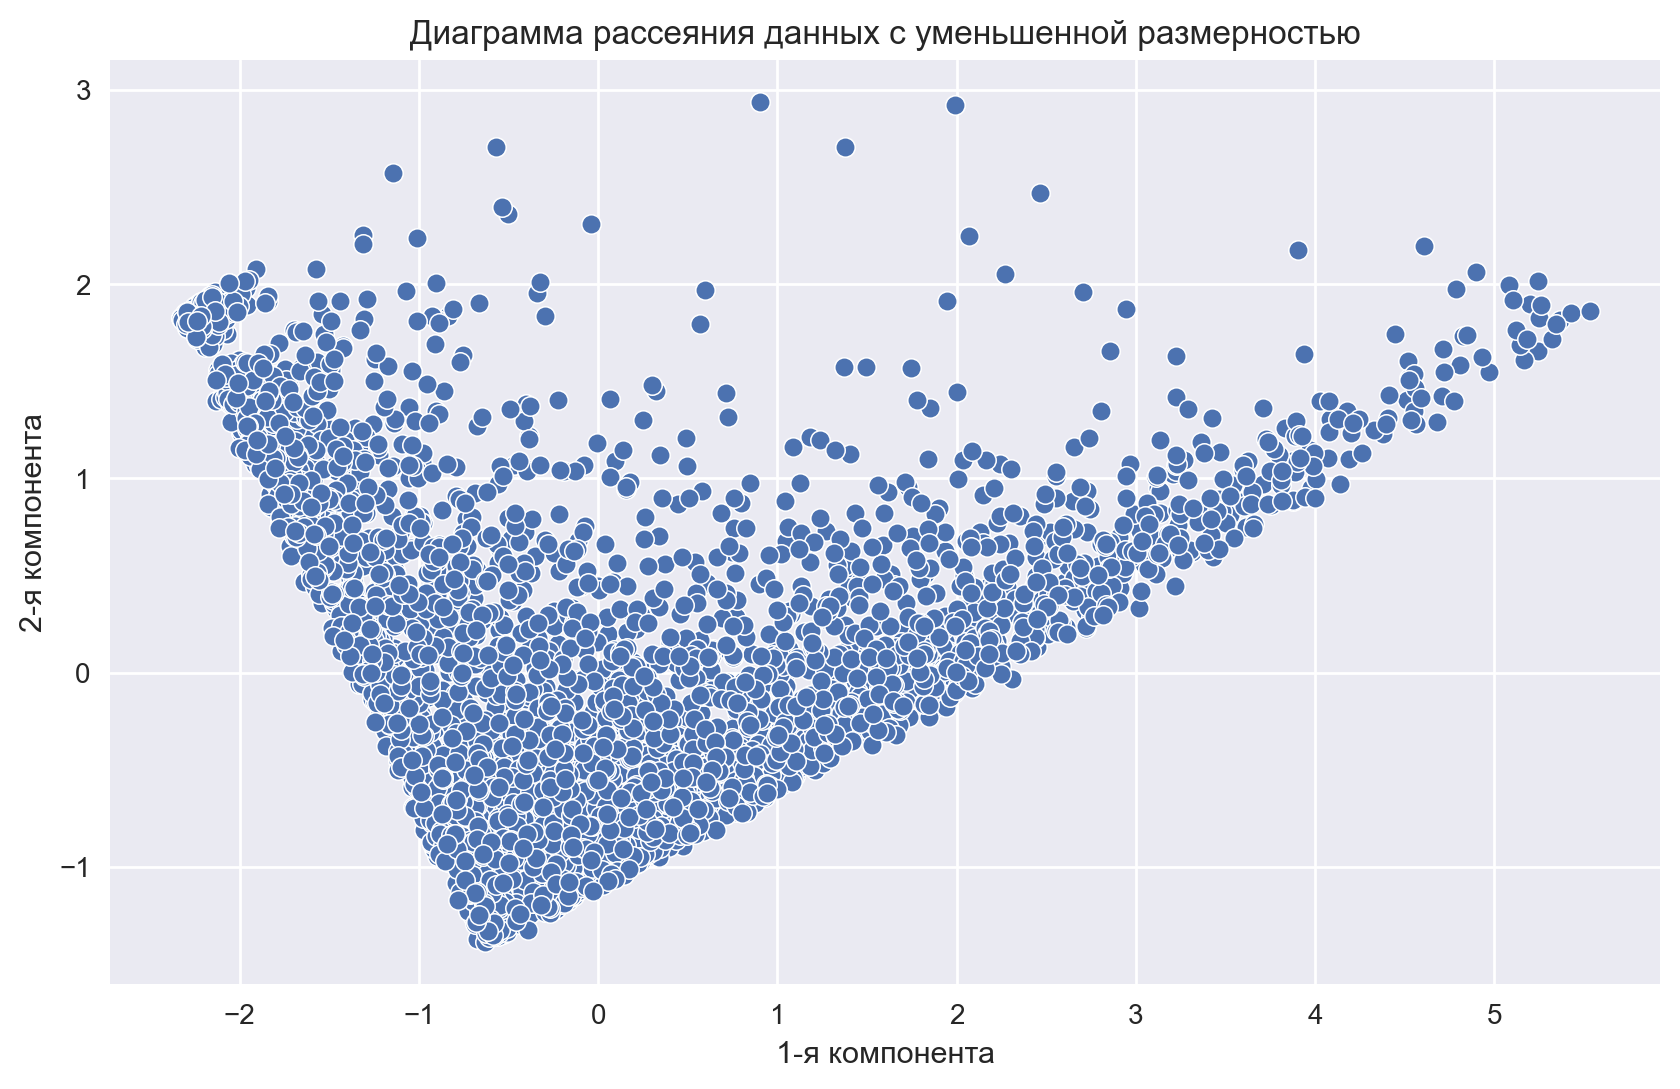

In [37]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=rfm_table_pca, x=rfm_table_pca[:,0], y=rfm_table_pca[:,1])
plt.title('Диаграмма рассеяния данных с уменьшенной размерностью')
plt.xlabel('1-я компонента')
plt.ylabel('2-я компонента')
plt.show();

Чисто визуально можно предположить наличие 3-х кластеров - в области "угла" внизу, а также слева и справа от него. Посмотрим, что получится в итоге и сравним с нашим предположением.

Вычислим коэффициент силуэта на кластервх от 3 до 10, используя алгоритмы **KMeans**, **AgglomerativeClustering**, **GaussianMixture**.

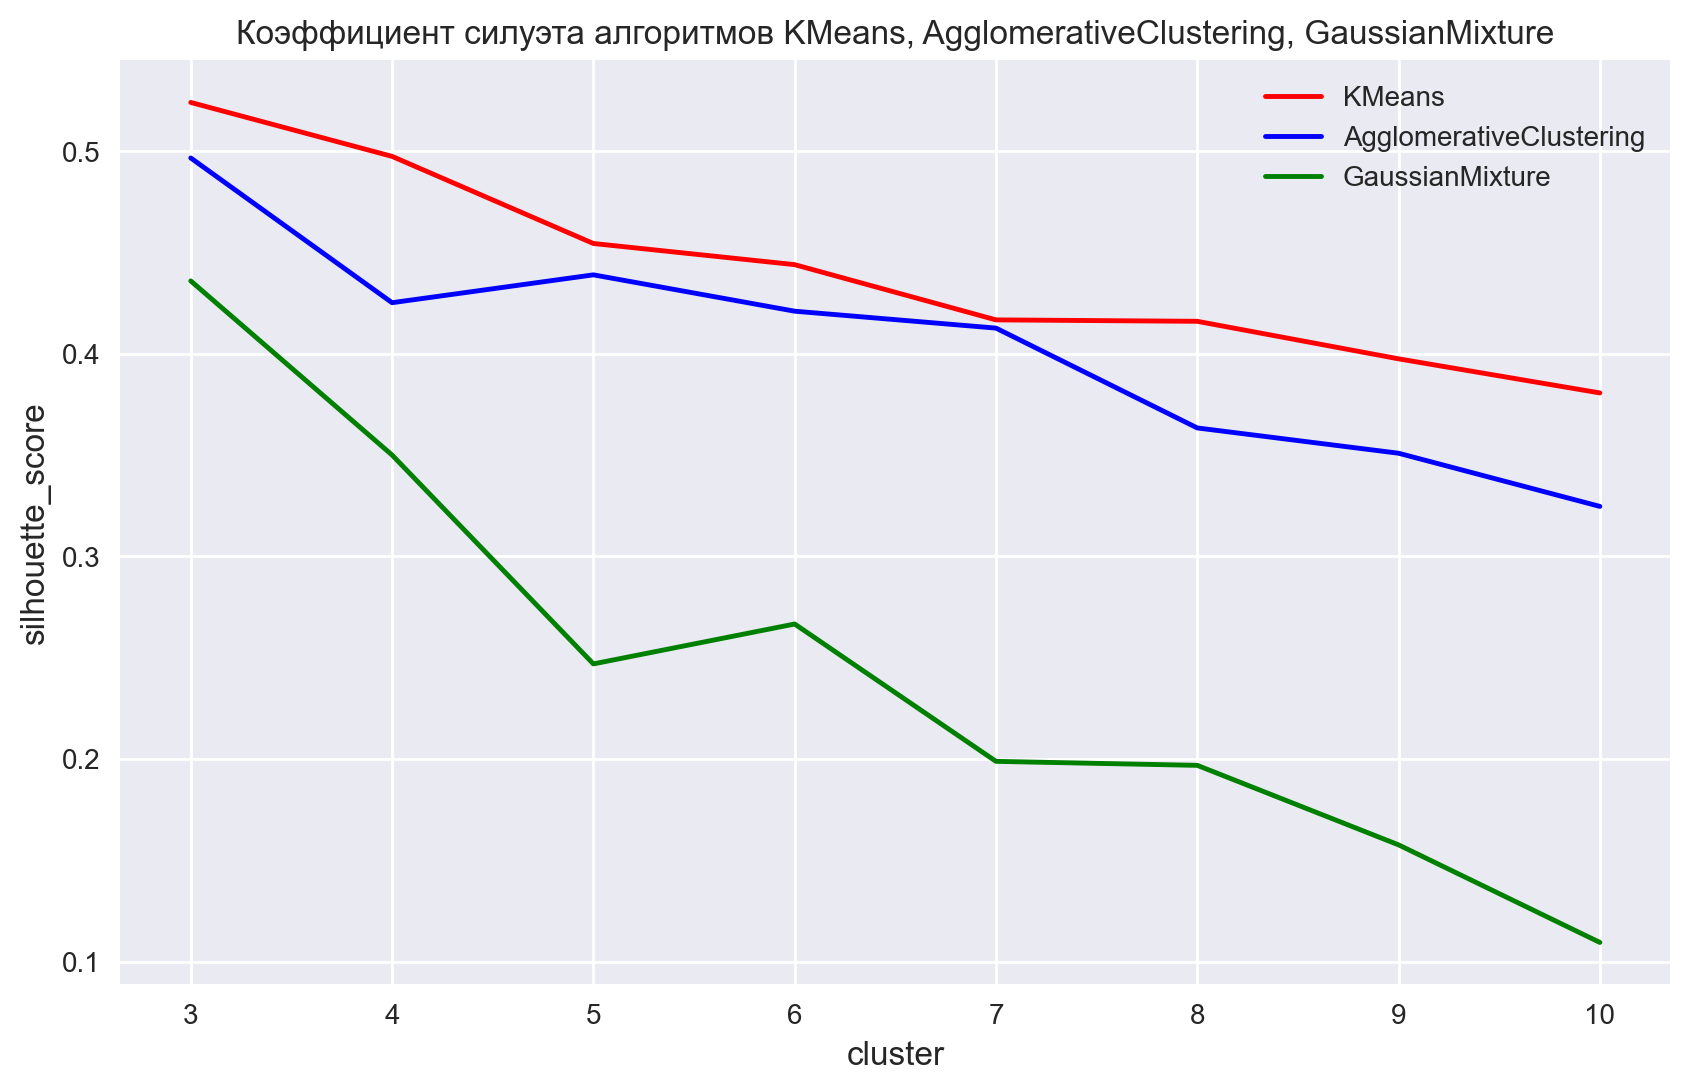

,cluster_number,silhouette_score_KMeans,silhouette_score_AgglomerativeClustering,silhouette_score_GaussianMixture
0,3,0.52,0.50,0.44
1,4,0.50,0.43,0.35
2,5,0.45,0.44,0.25
3,6,0.44,0.42,0.27
4,7,0.42,0.41,0.20
5,8,0.42,0.36,0.20
6,9,0.40,0.35,0.16
7,10,0.38,0.32,0.11


In [38]:

# создадим списки, где будут коэффициенты силуэта разных алгоритмов кластеризации
score_list_KMeans = []
score_list_AgglomerativeClustering = []
score_list_GaussianMixture = []

# расчитаем коэффициенты силуэта представленных выше алгоритмов
for cluster_num in range(3,11):
        score_list_KMeans.append(get_silhouette_score(cluster_num, rfm_table_pca, KMeans))
        score_list_AgglomerativeClustering.append(get_silhouette_score(cluster_num, rfm_table_pca, AgglomerativeClustering))
        score_list_GaussianMixture.append(get_silhouette_score(cluster_num, rfm_table_pca, GaussianMixture))

# визуализируем
plt.figure(figsize=(10,6))
plt.title("Коэффициент силуэта алгоритмов KMeans, AgglomerativeClustering, GaussianMixture")
plt.xlabel("cluster", fontsize=12)
plt.ylabel("silhouette_score", fontsize=12)
plt.plot([i for i in range(3, 11)], score_list_KMeans, 'xb-', color='r', label='KMeans')
plt.plot([i for i in range(3, 11)], score_list_AgglomerativeClustering, 'xb-', color='b', label='AgglomerativeClustering')
plt.plot([i for i in range(3, 11)], score_list_GaussianMixture, 'xb-', color='g', label='GaussianMixture')
plt.legend()
plt.show();

# выводим значения метрики и коэффициентов силуэта
cluster_metric = pd.DataFrame({
    'cluster_number': [i for i in range(3, 11)],
    'silhouette_score_KMeans': [ '%.2f' % elem for elem in score_list_KMeans ],
    'silhouette_score_AgglomerativeClustering': [ '%.2f' % elem for elem in score_list_AgglomerativeClustering ],
    'silhouette_score_GaussianMixture': [ '%.2f' % elem for elem in score_list_GaussianMixture ],
})
cluster_metric

Наибольшее значение коэффициента силуэта мы видим при количестве кластеров = 3 и при использовании алгоритма KMeans.

Проводим кластеризацию:
- алгоритм - **KMeans**
- количество кластеров - **3**

In [39]:
# создаем и обучаем алгоритм кластеризации KMeans
km = KMeans(n_clusters=3, random_state=42, init='random', max_iter=10000)
km.fit_predict(rfm_table_pca)

# получаем метки кластеров
predict = km.labels_

# обновим данные с уменьшенной размерностью
rfm_table_pca = np.append(rfm_table_pca, predict[:,None], axis=1)

# обновим исходные данные
rfm_table['cluster'] = predict

Визуализируем полученные кластеры на данных с пониженной размерностью.

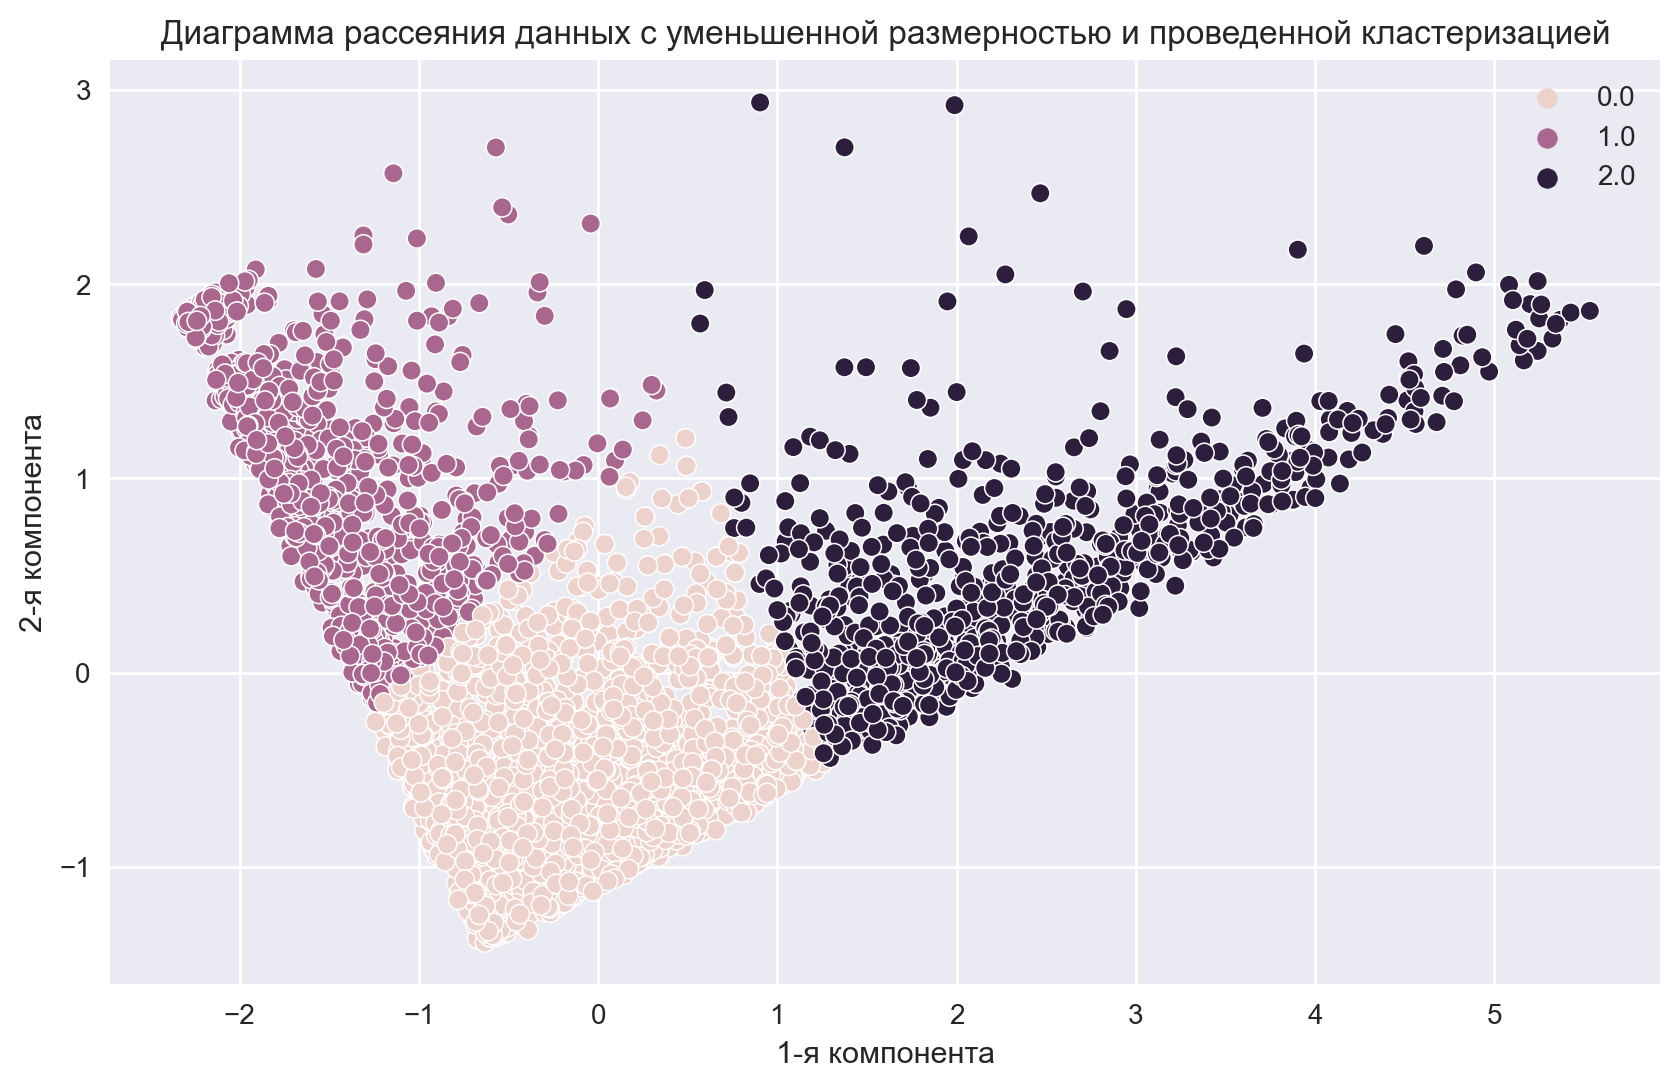

In [40]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=rfm_table_pca, x=rfm_table_pca[:,0], y=rfm_table_pca[:,1], hue=rfm_table_pca[:,2])
plt.title('Диаграмма рассеяния данных с уменьшенной размерностью и проведенной кластеризацией')
plt.xlabel('1-я компонента')
plt.ylabel('2-я компонента')
plt.show();

Мы получили 3 кластера там, где и предполагали выше.

## 4.2. Интерпретация результатов кластеризации

Перейдём к интерпретации полученных кластеров.

### 4.2.1. Визуализация кластеров

In [41]:
fig = px.scatter_3d(rfm_table, x='Recency', y='Frequency', z='Monetary', 
                    color='cluster')

# сохраним изображение и html
fig.write_html("plotly/diagram_2.html")
fig.write_image('plotly/img_2.svg')
#fig.show()

![Диаграмма рассеяния ](plotly/img_2.svg "Для просмотра HTML-версии нажмите ссылку ниже") 
  
[html-версия диаграммы рассеяния](plotly/diagram_2.html)

Интересный момент - если вывести в "фас" плоскость Frequency-Recency, то получим изображение, сильно напоминающее диаграмму выше: "Диаграмма рассеяния данных с уменьшенной размерностью и проведенной кластеризацией".

### 4.2.2. Построение профиля кластеров

In [42]:
def plot_cluster_profile(grouped_data, n_clusters):
    """Функция для визуализации профиля кластеров в виде полярной диаграммы.

    Args:
        grouped_data (DataFrame): таблица, сгруппированная по номерам кластеров с агрегированными характеристиками объектов.
        n_clusters (int): количество кластеров
    """
    # Нормализуем сгруппированные данные, приводя их к масштабу 0-1.
    scaler = MinMaxScaler()
    grouped_data = pd.DataFrame(scaler.fit_transform(grouped_data), columns=grouped_data.columns)
    # Создаём список признаков
    features = grouped_data.columns
    # Создаём пустую фигуру
    fig = go.Figure()
    # В цикле визуализируем полярную диаграмму для каждого кластера
    for i in range(n_clusters):
        # Создаём полярную диаграмму и добавляем её на общий график
        fig.add_trace(go.Scatterpolar(
            r=grouped_data.iloc[i].values, # радиусы
            theta=features, # название засечек
            fill='toself', # заливка многоугольника цветом
            name=f'Cluster {i}', # название — номер кластера
        ))
    # Обновляем параметры фигуры
    fig.update_layout(
        showlegend=True, # отображение легенды
        autosize=False, # устаналиваем свои размеры графика
        width=800, # ширина (в пикселях)
        height=800, # высота (в пикселях)
    )
    # Отображаем фигуру
    fig.show()

    # возращаем фигуру
    return fig

In [43]:
# выводим полярную диаграмму и RFM-таблицу, сгруппированную по средним значениям в кластерах
rfm_table_groupped_cluster = rfm_table.groupby(['cluster']).agg({
    'Recency':'mean',
    'Frequency':'mean',
    'Monetary':'mean'
})

fig = plot_cluster_profile(rfm_table_groupped_cluster, 3)
display(rfm_table_groupped_cluster)

fig.write_html("plotly/diagram_3.html")
fig.write_image('plotly/img_3.svg')


,Recency,Frequency,Monetary
cluster,,,
0,51.142542,2.327891,659.791037
1,253.283716,1.405594,386.598472
2,31.924067,7.065637,2656.277439


![Полярная диаграмма](plotly/img_3.svg "Для просмотра HTML-версии нажмите ссылку ниже") 
  
[html-версия полярной диаграммы](plotly/diagram_3.html)

In [44]:
# узнаем сколько клиентов в каждом кластере
rfm_table['cluster'].value_counts()

0    2266
1    1001
2     777
Name: cluster, dtype: int64

### 4.2.3. Выводы

- Была построена RFM-таблица, найдены и удалены выбросы, снижена размерность данных до 2-х компонент.
- Были опробованы алгоритмы кластеризации **KMeans**, **AgglomerativeClustering**, **GaussianMixture** и количество кластеров от 3 до 10. Выбран алгоритм **KMeans** и количество кластеров 3.
- Кластеры были визуализированы и изучены.
- Кластер №0: в среднем его покупатели осуществляли покупки 51 день назад, частота покупок 2.3 и тратили в среднем 659 фунтов. Данные показатели промежуточные между кластерами 1 и 2, но количество покупателей в данном кластере максимальная. Их можно отнести к **перспективным** клиентам.
- Кластер №1: давность последней покупки в среднем 253 дня назад, частота покупок 1.4 и тратили клиенты в среднем 386 фунтов - наихудшие показатели и второй по численности кластер.
- Кластер №2: в среднем покупки совершались 32 дня назад, частота покупок 7, потрачено в среднем 2656 фунтов - лучшие показатели, но это наименьшая группа клиентов. Данный кластер можно отнести к **лояльным** клиентам.

***

# 5. Дополнительно

Добавим следующую информацию:
- о среднем количестве покупаемого товара за один заказ для каждого клиента. То есть аббревиатура RFM превращается в RFMQ, где Q — среднее количество товаров в одном заказе. Это позволит выявить оптовиков.
- в какие месяцы клиенты покупают товары, т.е. попробуем выявить сезонность покупок.

## 5.1. Рассчитаем среднее количество товаров в одном заказе для каждого покупателя.

In [45]:
# группируем снова RFM-таблицу добавив признаки 
# Quantity_sum (суммарное количество товаров заказанное покупателем)
# Quantity_cancel_sum (суммарное количество отмененных товаров покупателем)
rfm_table = data.groupby(['CustomerID'], as_index=False).agg(
    Recency = pd.NamedAgg(column='InvoiceDate', aggfunc=lambda x: (datetime.datetime(2011,12,10,0,0,0) - x.max()).days),
    Frequency = pd.NamedAgg(column='InvoiceNo', aggfunc=lambda x: len(x.unique())),
    Monetary = pd.NamedAgg(column='TotalPrice', aggfunc='sum'),
    Quantity_sum = pd.NamedAgg(column='Quantity', aggfunc='sum'),
    Quantity_cancel_sum = pd.NamedAgg(column='QuantityCanceled', aggfunc='sum')
)

# расчитываем среднее количество товаров в покупке (до целого числа)
rfm_table['Quantity_mean'] = round((rfm_table['Quantity_sum'] - rfm_table['Quantity_cancel_sum']) / rfm_table['Frequency'])
rfm_table['Quantity_mean'] = rfm_table['Quantity_mean'].astype(int)

# удаляем ненужные признаки
rfmq_table = rfm_table.drop(['Quantity_sum','Quantity_cancel_sum'], axis=1)

print(rfmq_table.shape)
rfmq_table.head()


(4334, 5)


,CustomerID,Recency,Frequency,Monetary,Quantity_mean
0,12346,325,1,0.00,0
1,12347,2,7,4310.00,351
2,12348,75,4,1437.24,583
3,12349,18,1,1457.55,630
4,12350,310,1,294.40,196


## 5.2. Рассчитаем количество покупок в месяц для каждого покупателя.

In [46]:
# создадим признак InvoiceDate_month который указывает месяц транзакции
data['InvoiceDate_month'] = data['InvoiceDate'].dt.month

# создадим промежуточный датасет сгруппировав данные по покупателям и месяцам транзакций
# расчитаем количество уникальных транзакций (т.е. количество покупок)
data_temp = data.groupby(['CustomerID','InvoiceDate_month'], as_index=False).agg(
    purchase_num = pd.NamedAgg(column='InvoiceNo', aggfunc=lambda x: len(x.unique()))
)

# в промежуточном датасете создадим новые признаки месяцев от month_1 до month_12 и заполним их 
# количеством покупок в данном месяце
for i in range(1,13):
    data_temp['month_' + str(i)] = data_temp.apply(
        lambda row: row['purchase_num'] if row['InvoiceDate_month'] == i else 0, axis=1
    )

# создадим датасет, сгруппировав данные по покупателям и посчитав
# сумму покупок по месяцам для каждого покупателя
data_purchase_month = data_temp.groupby(['CustomerID'], as_index=False).agg(
    month_1 = pd.NamedAgg(column='month_1', aggfunc='sum'),
    month_2 = pd.NamedAgg(column='month_2', aggfunc='sum'),
    month_3 = pd.NamedAgg(column='month_3', aggfunc='sum'),
    month_4 = pd.NamedAgg(column='month_4', aggfunc='sum'),
    month_5 = pd.NamedAgg(column='month_5', aggfunc='sum'),
    month_6 = pd.NamedAgg(column='month_6', aggfunc='sum'),
    month_7 = pd.NamedAgg(column='month_7', aggfunc='sum'),
    month_8 = pd.NamedAgg(column='month_8', aggfunc='sum'),
    month_9 = pd.NamedAgg(column='month_9', aggfunc='sum'),
    month_10 = pd.NamedAgg(column='month_10', aggfunc='sum'),
    month_11 = pd.NamedAgg(column='month_12', aggfunc='sum'),
    month_12 = pd.NamedAgg(column='month_12', aggfunc='sum'),
)

print(data_purchase_month.shape)
data_purchase_month.head()

(4334, 13)


,CustomerID,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,12346,1,0,0,0,0,0,0,0,0,0,0,0
1,12347,1,0,0,1,0,1,0,1,0,1,2,2
2,12348,1,0,0,1,0,0,0,0,1,0,1,1
3,12349,0,0,0,0,0,0,0,0,0,0,0,0
4,12350,0,1,0,0,0,0,0,0,0,0,0,0


## 5.3. EDA

Визуализируем новый признак *Quantity_mean*.

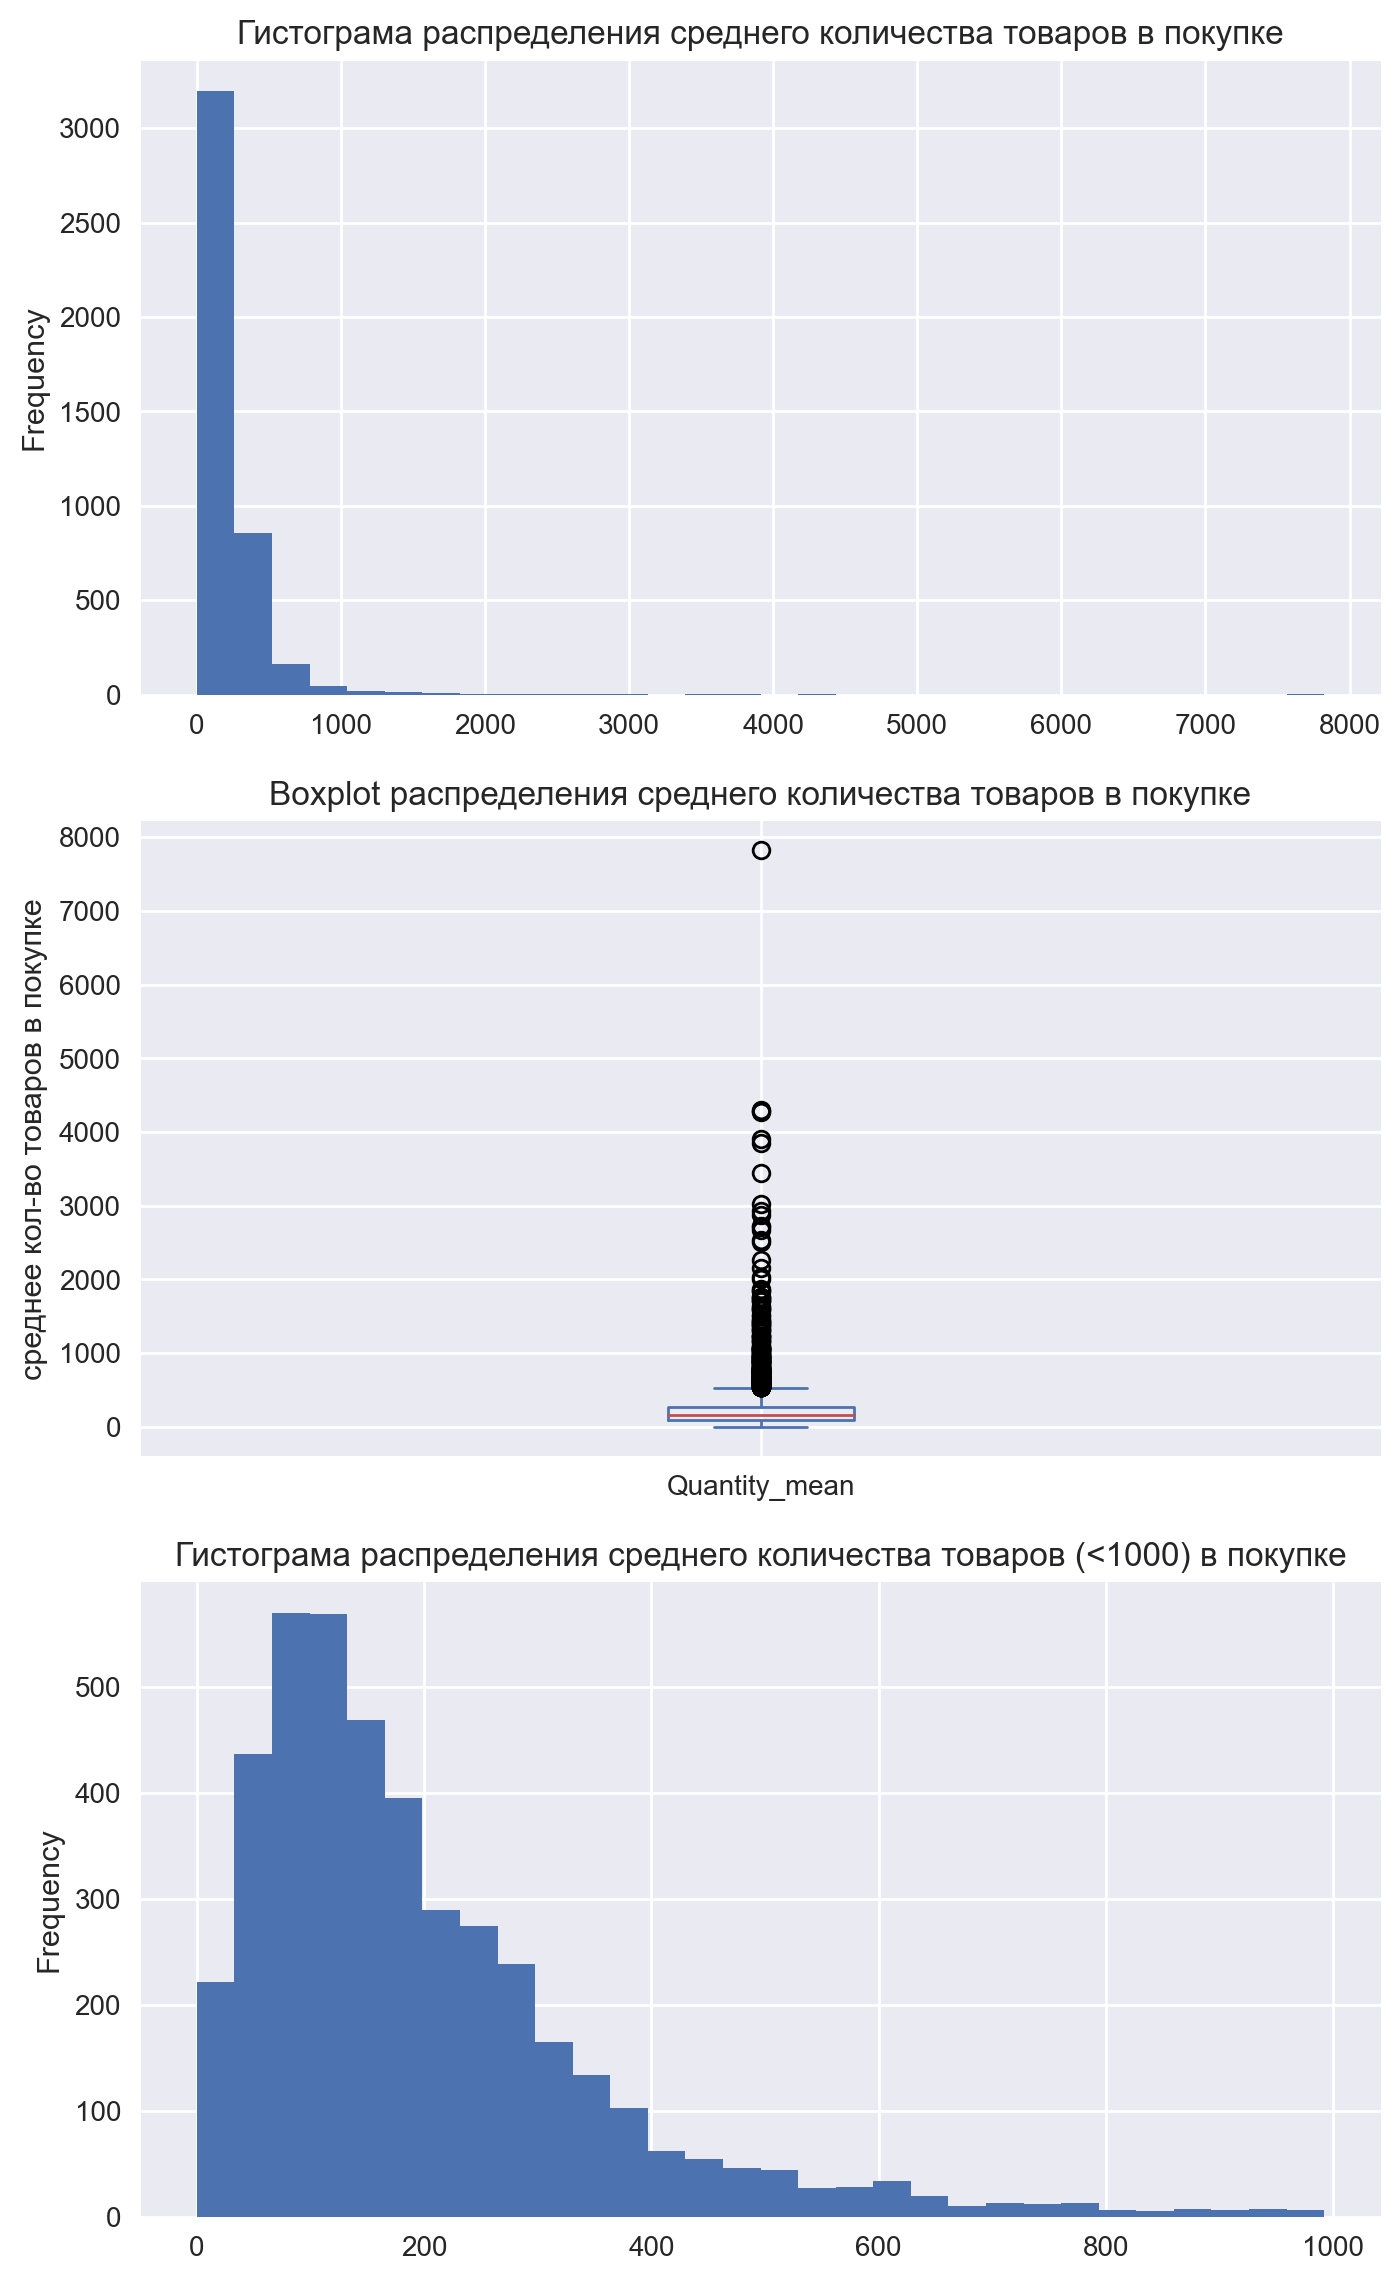

In [47]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 14))

rfmq_table['Quantity_mean'].plot(
    x = 'Quantity_mean',
    kind='hist',
    bins=30,
    title='Гистограма распределения среднего количества товаров в покупке',
    ax=axes[0]
);

rfmq_table['Quantity_mean'].plot(
    x = 'Quantity_mean',
    kind='box',
    title='Boxplot распределения среднего количества товаров в покупке',
    ylabel='среднее кол-во товаров в покупке',
    ax=axes[1]
);

mask = rfm_table['Quantity_mean'] < 1000
rfm_table[mask]['Quantity_mean'].plot(
    x = 'Quantity_mean',
    kind='hist',
    bins=30,
    title='Гистограма распределения среднего количества товаров (<1000) в покупке',
    ax=axes[2]
);

Визуализируем распределение покупок по месяцам.

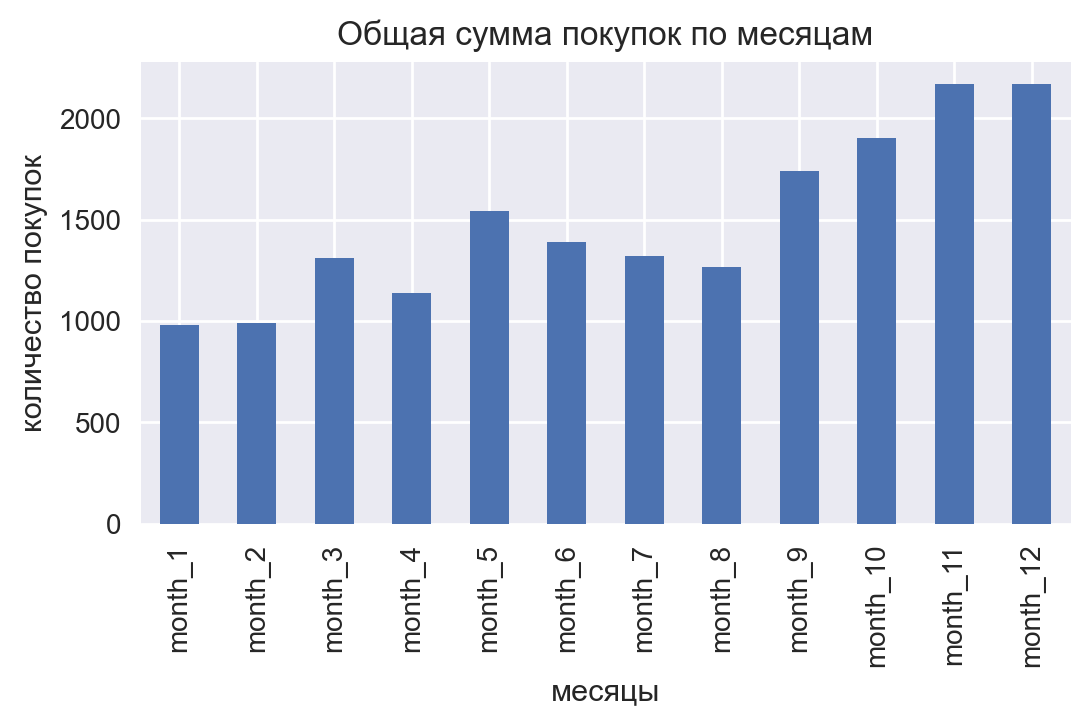

In [48]:
# суммируем покупки по месяцам
data_purchase_month_sum = data_purchase_month.sum().iloc[1:]
# визуализируем полученные данные
data_purchase_month_sum.plot(
    figsize=(6, 3),
    kind='bar',
    title='Общая сумма покупок по месяцам',
    xlabel='месяцы',
    ylabel='количество покупок'
);

**Выводы:**
- чаще всего в одной покупке в среднем 30-300 товаров
- имеется явный выброс среднего количества товаров в покупке около 8000, подлежит удалению
- отмечается некоторая сезонность покупок: наименьшее количество в январе-феврале, небольшой рост в марте (вероятно, из-за праздника 8 Марта), следующий рост в мае (вероятно, майские праздники), затем летом количество покупок последовательно снижается и с сентября начинает расти до декабря. Примечание: в декабре наложились покупки за 2010 и 2011 годы (в 2011 году 1-9 декабря).

Удалим выбросы и добавим в RFMQ-таблицу данные о количестве покупок по месяцам.

In [49]:
# выделим выброс в признаке Quantity_mean
outlier = rfmq_table[rfmq_table['Quantity_mean'] > 5000]
outlier

,CustomerID,Recency,Frequency,Monetary,Quantity_mean
4310,18251,87,1,4314.72,7824


In [50]:
# размерность данных до удаления
print(f'rfmq_table {rfmq_table.shape}')
print(f'data_purchase_month {data_purchase_month.shape}')

# удалим этого покупателя в обеих новых таблицах
rfmq_table = rfmq_table.loc[rfmq_table['CustomerID'] != '18251']
data_purchase_month = data_purchase_month.loc[data_purchase_month['CustomerID'] != '18251']

# размерность данных после удаления
print(f'rfmq_table {rfmq_table.shape}')
print(f'data_purchase_month {data_purchase_month.shape}')

rfmq_table (4334, 5)
data_purchase_month (4334, 13)
rfmq_table (4333, 5)
data_purchase_month (4333, 13)


In [51]:
# добавим в RFMQ-таблицу данные по месячным покупкам
rfmq_table = rfmq_table.merge(data_purchase_month, on='CustomerID', how='left')

print(rfmq_table.shape)
rfmq_table.head()

(4333, 17)


,CustomerID,Recency,Frequency,Monetary,Quantity_mean,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,12346,325,1,0.00,0,1,0,0,0,0,0,0,0,0,0,0,0
1,12347,2,7,4310.00,351,1,0,0,1,0,1,0,1,0,1,2,2
2,12348,75,4,1437.24,583,1,0,0,1,0,0,0,0,1,0,1,1
3,12349,18,1,1457.55,630,0,0,0,0,0,0,0,0,0,0,0,0
4,12350,310,1,294.40,196,0,1,0,0,0,0,0,0,0,0,0,0


## 5.4. Подбор алгоритма и параметров кластеризации

Подбирались следующие параметры кластеризации клиентов магазина:
- различные комбинации признаков итоговой RFMQ-таблицы
- различное количество компонент при уменьшении размерности
- различные алгоритмы и количество кластеров

Ниже представлены итоговые параметры.

In [52]:
# создадим pipeline
pipeline = Pipeline([
    # стандартизация данных
    ('scaler', StandardScaler()), 
    # снижение размерности данных
    ('pca', PCA(n_components=2))
])

# стандартизируем и уменьшаем размерность данных
rfmq_table_pca = pipeline.fit_transform(rfmq_table)

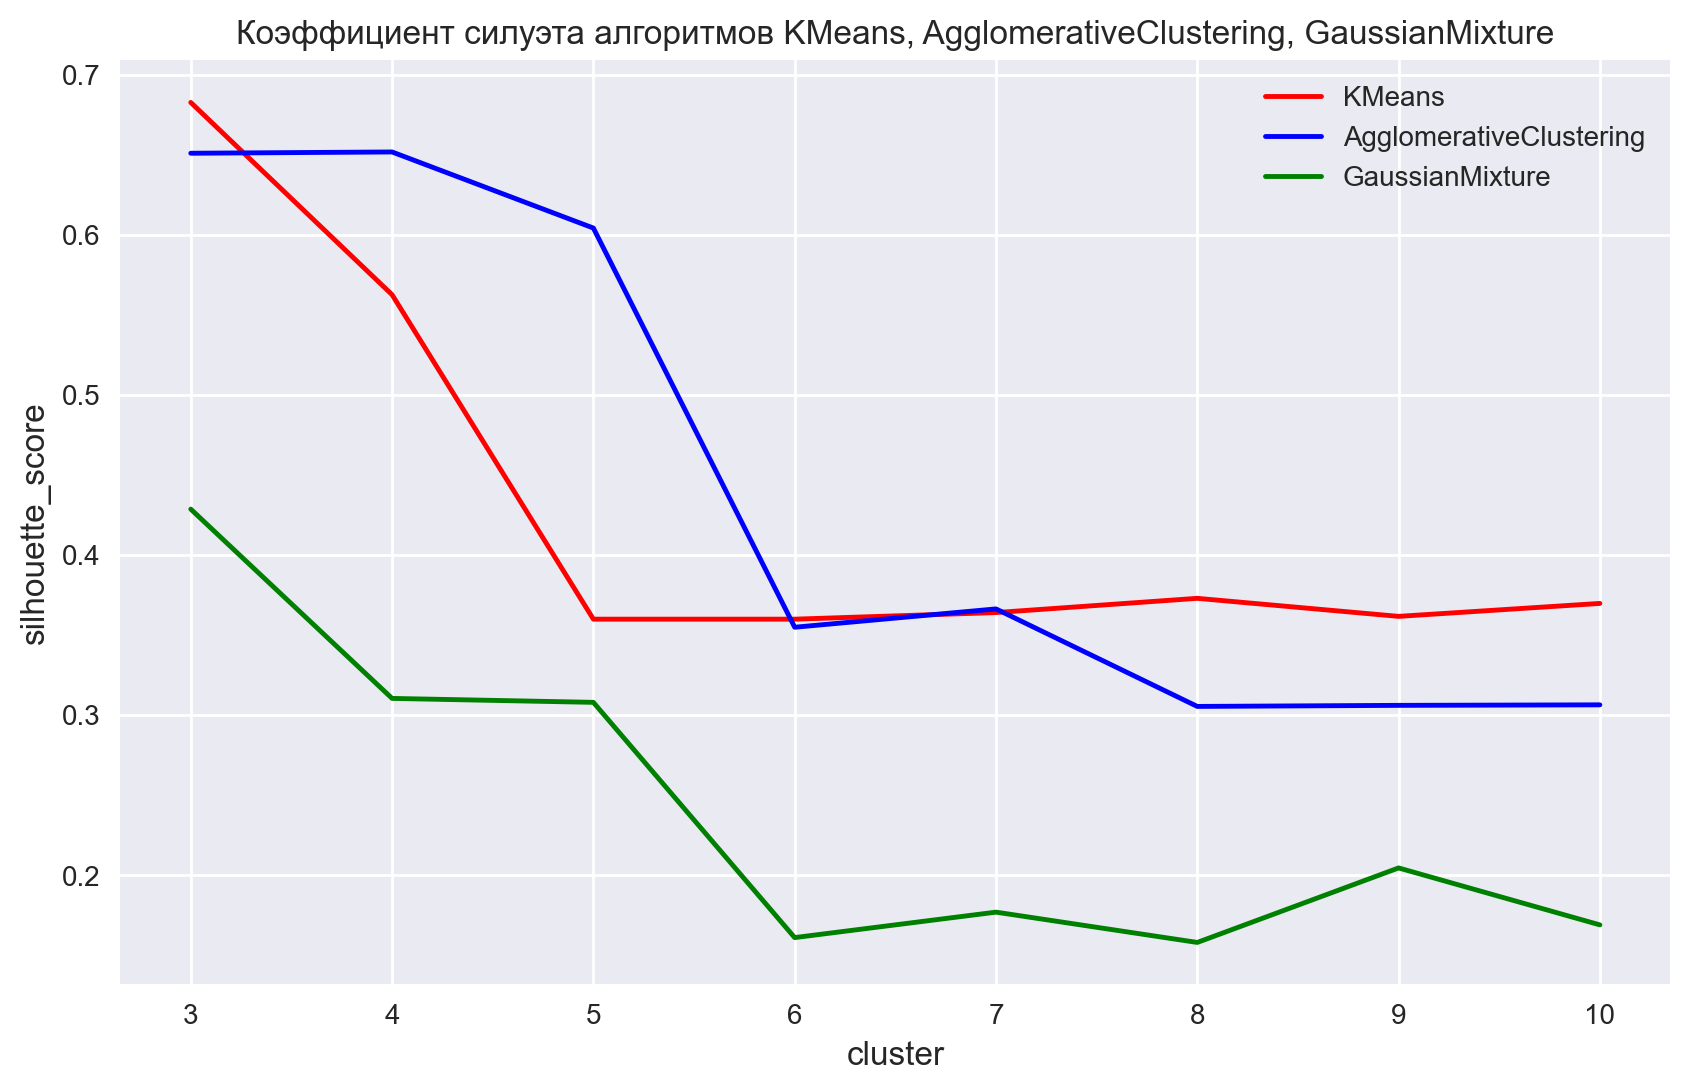

,cluster_number,silhouette_score_KMeans,silhouette_score_AgglomerativeClustering,silhouette_score_GaussianMixture
0,3,0.68,0.65,0.43
1,4,0.56,0.65,0.31
2,5,0.36,0.60,0.31
3,6,0.36,0.35,0.16
4,7,0.36,0.37,0.18
5,8,0.37,0.31,0.16
6,9,0.36,0.31,0.20
7,10,0.37,0.31,0.17


In [53]:

# создадим списки, где будут коэффициенты силуэта разных алгоритмов кластеризации
score_list_KMeans = []
score_list_AgglomerativeClustering = []
score_list_GaussianMixture = []

# расчитаем коэффициенты силуэта представленных выше алгоритмов
for cluster_num in range(3,11):
        score_list_KMeans.append(get_silhouette_score(cluster_num, rfmq_table_pca, KMeans))
        score_list_AgglomerativeClustering.append(get_silhouette_score(cluster_num, rfmq_table_pca, AgglomerativeClustering))
        score_list_GaussianMixture.append(get_silhouette_score(cluster_num, rfmq_table_pca, GaussianMixture))

# визуализируем
plt.figure(figsize=(10,6))
plt.title("Коэффициент силуэта алгоритмов KMeans, AgglomerativeClustering, GaussianMixture")
plt.xlabel("cluster", fontsize=12)
plt.ylabel("silhouette_score", fontsize=12)
plt.plot([i for i in range(3, 11)], score_list_KMeans, 'xb-', color='r', label='KMeans')
plt.plot([i for i in range(3, 11)], score_list_AgglomerativeClustering, 'xb-', color='b', label='AgglomerativeClustering')
plt.plot([i for i in range(3, 11)], score_list_GaussianMixture, 'xb-', color='g', label='GaussianMixture')
plt.legend()
plt.show();

# выводим значения метрики и коэффициентов силуэта
cluster_metric = pd.DataFrame({
    'cluster_number': [i for i in range(3, 11)],
    'silhouette_score_KMeans': [ '%.2f' % elem for elem in score_list_KMeans ],
    'silhouette_score_AgglomerativeClustering': [ '%.2f' % elem for elem in score_list_AgglomerativeClustering ],
    'silhouette_score_GaussianMixture': [ '%.2f' % elem for elem in score_list_GaussianMixture ],
})
cluster_metric

Выполняем кластеризацию.

In [54]:
# создаем и обучаем алгоритм кластеризации KMeans
km = KMeans(n_clusters=3, random_state=42, init='random', max_iter=10000)
km.fit_predict(rfmq_table_pca)

# получаем метки кластеров
predict = km.labels_

# обновим исходные данные
rfmq_table['cluster'] = predict

## 5.5. Визуализация и интерпретация результатов кластеризации

In [55]:
# выводим полярную диаграмму и RFM-таблицу, сгруппированную по средним значениям в кластерах

# группируем данные
rfmq_table_groupped_cluster = rfmq_table.groupby(['cluster'], as_index=False).agg({
    'Recency':'mean',
    'Frequency':'mean',
    'Monetary':'mean',
    'Quantity_mean':'mean',

    'month_1':'mean',
    'month_2':'mean',
    'month_3':'mean',
    'month_4':'mean',
    'month_5':'mean',
    'month_6':'mean',
    'month_7':'mean',
    'month_8':'mean',
    'month_9':'mean',
    'month_10':'mean',
    'month_11':'mean',
    'month_12':'mean',
})
# выводим диаграмму и данные
fig = plot_cluster_profile(rfmq_table_groupped_cluster, 3)
display(rfmq_table_groupped_cluster.sort_values(by='Recency'))

fig.write_html("plotly/diagram_4.html")
fig.write_image('plotly/img_4.svg')

,cluster,Recency,Frequency,Monetary,Quantity_mean,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
1,1,4.904762,78.285714,76688.700476,665.857143,4.666667,4.428571,5.857143,4.523810,7.047619,6.428571,5.809524,5.476190,7.809524,7.380952,9.428571,9.428571
0,0,20.883544,15.556962,7207.705772,259.696203,0.908861,0.934177,1.146835,1.086076,1.463291,1.278481,1.179747,1.169620,1.303797,1.255696,2.113924,2.113924
2,2,99.890477,2.709216,970.582533,217.043401,0.134286,0.135308,0.187899,0.157008,0.208833,0.191473,0.187133,0.176155,0.270360,0.319632,0.290273,0.290273


![Полярная диаграмма](plotly/img_4.svg "Для просмотра HTML-версии нажмите ссылку ниже") 
  
[html-версия полярной диаграммы](plotly/diagram_4.html)

In [56]:
# узнаем сколько клиентов в каждом кластере
rfmq_table['cluster'].value_counts()

2    3917
0     395
1      21
Name: cluster, dtype: int64

Изучим сезонность покупок в разрезе кластеров.

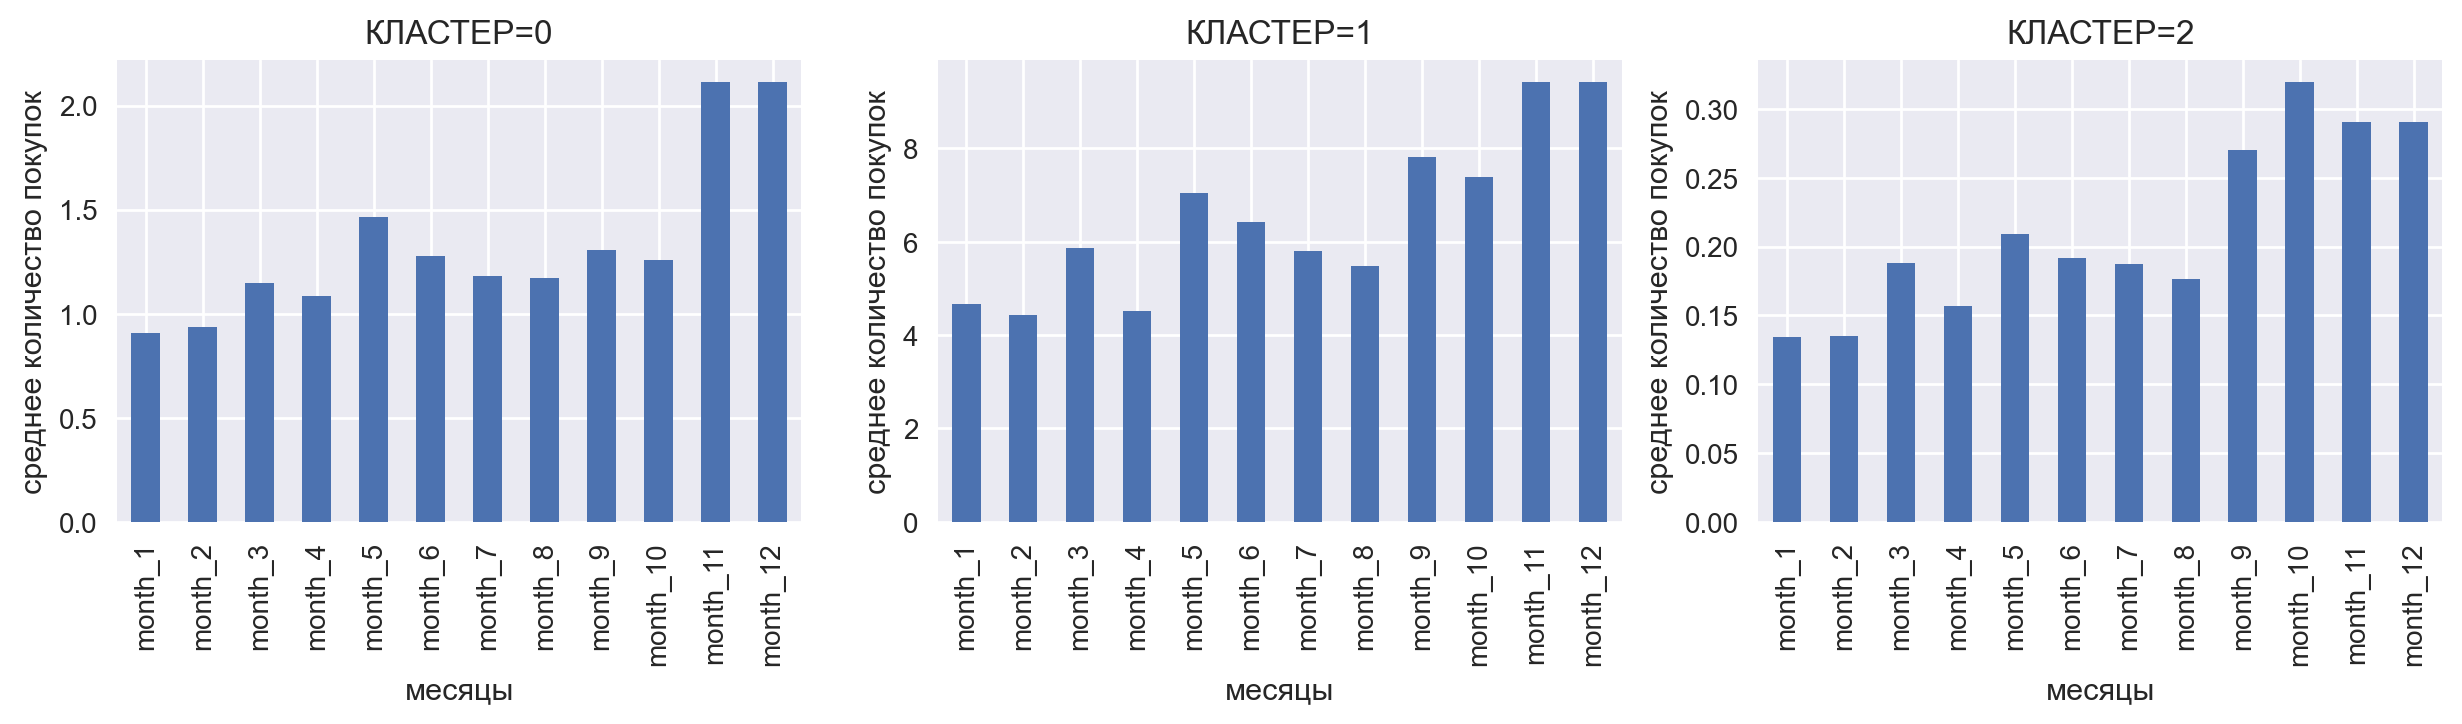

In [57]:
# определим количество кластеров
cluster_num = len(rfmq_table_groupped_cluster)
# визуализируем искомые данные
fig, axes = plt.subplots(nrows=1, ncols=cluster_num, figsize=(cluster_num*5, 3))

for cluster in range(cluster_num):

    rfmq_table_groupped_cluster[rfmq_table_groupped_cluster['cluster'] == cluster].iloc[0,5:].plot(
        kind='bar',
        xlabel='месяцы',
        ylabel='среднее количество покупок',
        title=f'КЛАСТЕР={cluster}',
        ax=axes[cluster]
    )

plt.show();

Получим данные о странах проживания клиентов в разрезе кластеров.

In [58]:
# группируем данные
data_country = data[['CustomerID', 'Country']].drop_duplicates(subset='CustomerID')

# добавим в RFMQ-таблицу данные по странам проживания
rfmq_table = rfmq_table.merge(data_country, on='CustomerID', how='left')

In [59]:
# группируем данные
rfmq_country = rfmq_table.groupby(['cluster','Country']).agg({'Country':'count'}).\
    rename(columns={'Country':'Count'}).sort_values(by=['cluster', 'Count'], ascending=False)

print('Распределение клиентов по странам в кластерах 0 и 1')
display(rfmq_country[-10:])
print('Распределение клиентов по ТОП-10 странам в кластере 2')
display(rfmq_country[:10])

Распределение клиентов по странам в кластерах 0 и 1


Count
cluster Country              
1       United Kingdom     18
        EIRE                2
        Netherlands         1
0       United Kingdom    363
        Germany            14
        France             10
        Belgium             4
        Australia           2
        Spain               1
        Sweden              1

Распределение клиентов по ТОП-10 странам в кластере 2


Count
cluster Country              
2       United Kingdom   3534
        Germany            80
        France             77
        Spain              27
        Belgium            20
        Switzerland        20
        Portugal           19
        Italy              14
        Finland            12
        Norway             10

Визуализируем данные с уменьшенной размерностью до и после кластеризации.

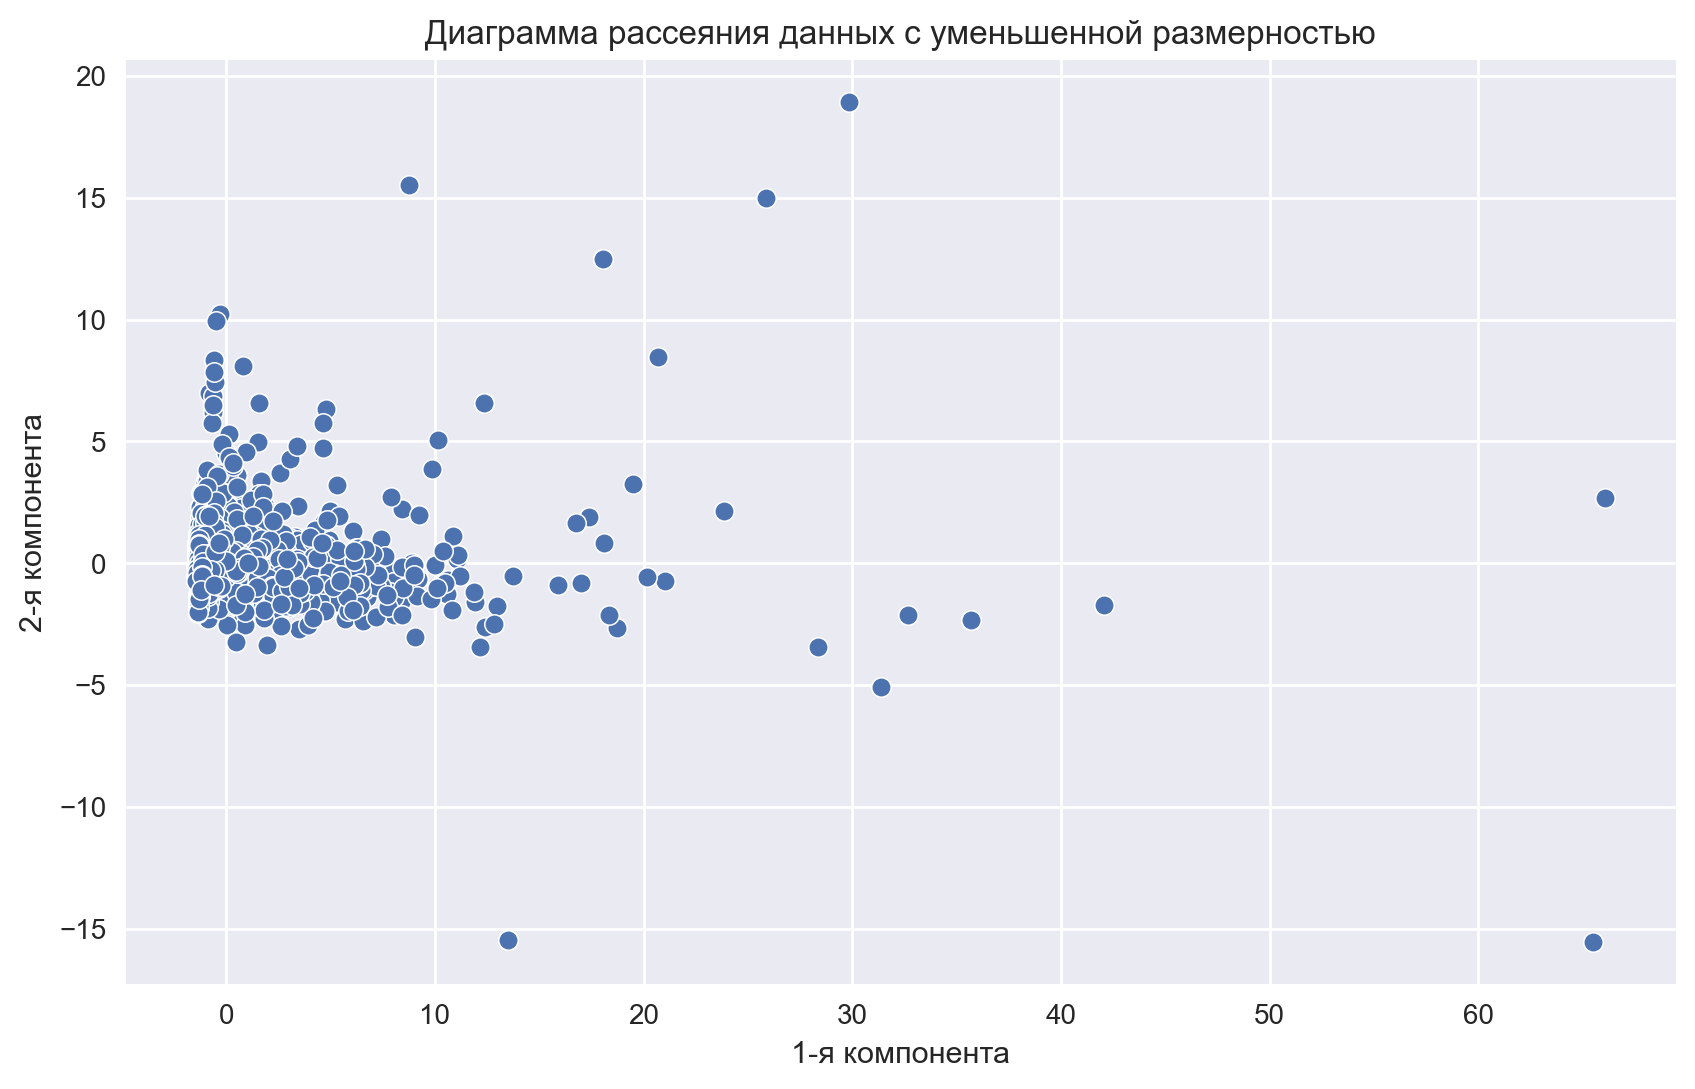

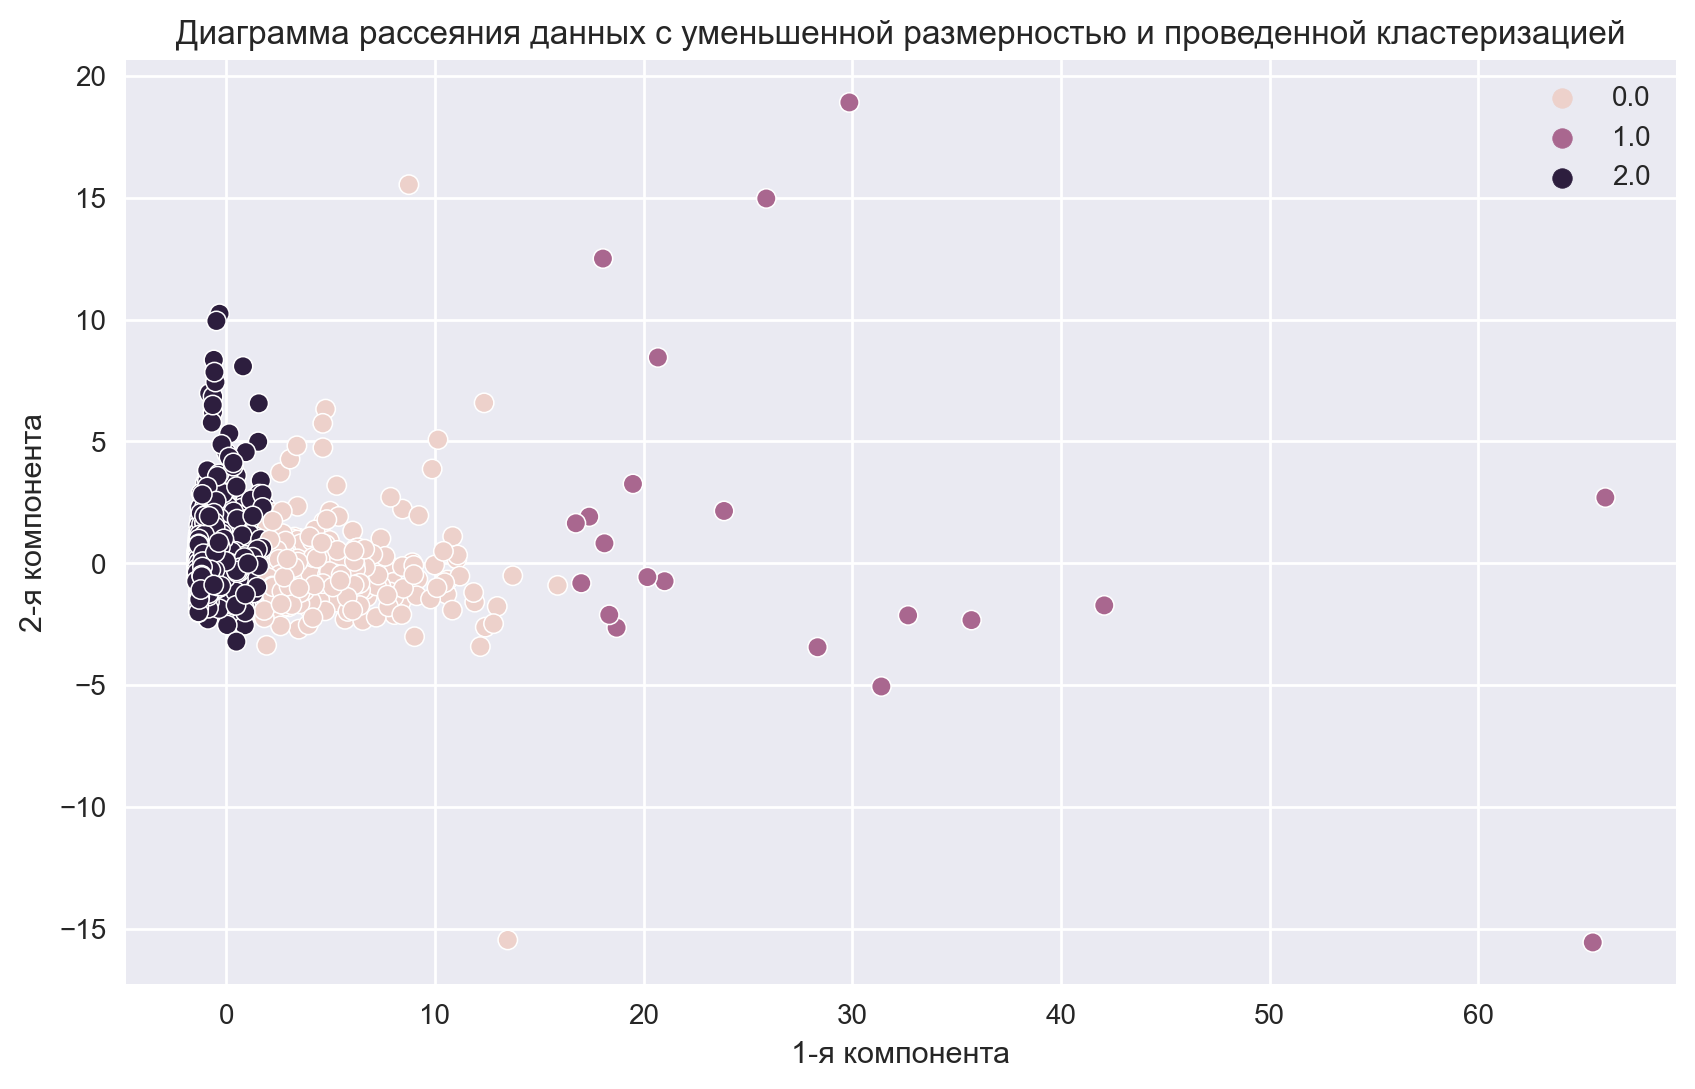

In [60]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=rfmq_table_pca, x=rfmq_table_pca[:,0], y=rfmq_table_pca[:,1])
plt.title('Диаграмма рассеяния данных с уменьшенной размерностью')
plt.xlabel('1-я компонента')
plt.ylabel('2-я компонента')
plt.show();

# обновим данные с уменьшенной размерностью
rfmq_table_pca = np.append(rfmq_table_pca, predict[:,None], axis=1)

plt.figure(figsize=(10,6))
sns.scatterplot(data=rfmq_table_pca, x=rfmq_table_pca[:,0], y=rfmq_table_pca[:,1], hue=rfmq_table_pca[:,2])
plt.title('Диаграмма рассеяния данных с уменьшенной размерностью и проведенной кластеризацией')
plt.xlabel('1-я компонента')
plt.ylabel('2-я компонента')
plt.show();

3D-визуализация полученных кластеров в разрезе 3-х признаков: *Recency*, *Frequency*, *Monetary*.

In [61]:
fig = px.scatter_3d(rfmq_table, x='Recency', y='Frequency', z='Monetary', 
                    color='cluster')

# сохраняем диаграмму в svg и html
fig.write_html("plotly/diagram_5.html")
fig.write_image('plotly/img_5.svg')
#fig.show()

![Диаграмма рассеяния](plotly/img_5.svg "Для просмотра HTML-версии нажмите ссылку ниже") 
  
[html-версия диаграммы рассеяния](plotly/diagram_5.html)

## 5.5. Выводы

- коэффициент силуэта во втором случае выше, что говорит о более качествееном разделении клиентов.
- судя по диаграммам рассеяния данных с пониженной размерностью, разделение по кластерам шло примерно по линиям перпендикулярным оси абсцисс (1-я компонента).
- кластер №1: наименьший (только 21 клиент), последняя покупка 5 дней назад, частота 78, потрачено 76689 фунтов в среднем. Среднее количество товаров в заказе - 666. Это **крупные оптовики**. Расположены в Великобритании (18), Ирландии (2) и Нидерландах (1). Наблюдается определенная сезонность - пики в марте, мае, сентябре и ноябре-декабре.
- кластер №0: является промежуточным по количеству клиентов (395), по дате последней покупки (21 день назад) и частоте (16), а также по потраченной средней сумме (более 7000 фунтов) и среднему количеству товаров в заказе (260). Как и в других кластерах расположены в подавляющем большинстве в Великобритании, а также в других странах Западной Европы, правда, можно отметить 2-х клиентов из Австралии. Сезонность примерно такая же, как и в предыдущем кластере. Все вышеуказанное может говорить о том, что это **более мелкие оптовики** (по крайней мере бОльшая часть кластера). 
- кластер №2: наибольший по численности, но наихудший по показателям - последний заказ 99 дней назад, частота 2.7, потрачено 970 фунтов и в среднем 217 товаров в заказе. Сезонность также несколько отличается - по сравнению с предыдущими клиентами мы видим пик в октябре, но потом некоторое снижение в ноябре-декабре.
- клиентов кластеров №№0и1 можно отнести к **лояльным**, клиентов кластера №2 - к **зоне риска**.